In [463]:
#!pip install govuk-bank-holidays

import pandas as pd
import numpy as np
from scipy.special import expit, logit
import matplotlib.pyplot as plt
from collections import deque
import heapq
from govuk_bank_holidays.bank_holidays import BankHolidays

In [464]:
# Import future ENT appointments
data = pd.read_csv("../future_appts_trans_ENT.csv")
data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,appt_date,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,17479744,57,27.45,1,0,1,1,0,0,0,...,2024-06-26,3,7,0,6,0,10,1,0,3
1,17631073,17,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,1,0,3
2,17659262,27,21.70,0,0,0,4,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,2
3,17659348,57,21.70,0,0,0,3,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,3
4,17659361,27,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,20183628,47,27.45,0,0,1,2,0,0,0,...,2024-06-19,5,7,0,6,0,10,1,0,1
2556,20183649,57,40.00,0,1,0,1,0,0,0,...,2024-06-08,3,7,0,5,0,10,2,0,3
2557,20183782,32,21.70,0,0,0,4,0,0,0,...,2024-05-25,3,7,0,7,0,10,6,0,1
2558,20183795,62,39.45,0,0,0,1,0,0,0,...,2024-06-17,3,7,0,6,0,10,3,0,1


In [465]:
# Filter for surgeons & new appointments only
surgeon_new = data[data["reason_display"].isin(["Adult ENT New", "Adult ENT Thyroid New"])]

# Count number of unique appointments
total_appts = surgeon_new["appointment_id"].nunique()
total_appts


2208

In [466]:
# Within the surgeons & new appointments only, filter for very high risk appointments
surgeon_new_very_high = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] == 4]

In [467]:
# Count number of unique appointment durations
surgeon_new["appt_duration"].value_counts()

appt_duration
15.0    1958
30.0     198
20.0      33
10.0      16
75.0       3
Name: count, dtype: int64

In [468]:
# Split out the appointment durations
surgeon_new_10 = surgeon_new[surgeon_new["appt_duration"] == 10]
surgeon_new_15 = surgeon_new[surgeon_new["appt_duration"] == 15]
surgeon_new_20 = surgeon_new[surgeon_new["appt_duration"] == 20]
surgeon_new_30 = surgeon_new[surgeon_new["appt_duration"] == 30]
surgeon_new_75 = surgeon_new[surgeon_new["appt_duration"] == 75]

# Split out the very high risk appointments
surgeon_new_very_high_10 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 10]
surgeon_new_very_high_15 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 15]
surgeon_new_very_high_20 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 20]
surgeon_new_very_high_30 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 30]
surgeon_new_very_high_75 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 75]

In [469]:
# # Group weekswaiting as per NHS guidelines
# data["weekswaiting"]
# data["weekswaiting_grouped"] = pd.cut(data["weekswaiting"], bins=[0, 17, 51, 76, float("inf")], labels=["0-17", "18-51", "52-77", ">78"])
# data[["weekswaiting","weekswaiting_grouped"]]

### M1: Calculate max capacity (per weekday) for new surgeon appointments and overbook by creating extra time slots 

In [470]:
# Import historic ENT appointments
historic = pd.read_csv("../historic_appts_first_pred_trans_ENT.csv")
historic.head()

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,12088942,42,27.45,NaN,0,0,0,4,0,1,...,First prediction,1.0,3,2024-02-14,2,3,10,6,0,3
1,12207851,42,27.45,NaN,1,0,1,4,0,0,...,First prediction,1.0,3,2024-03-12,3,3,10,6,0,4
2,12791383,27,21.70,NaN,0,0,0,3,0,0,...,First prediction,1.0,3,2024-01-31,1,3,10,6,0,2
3,12940266,42,27.45,NaN,1,0,0,2,0,0,...,First prediction,1.0,3,2024-04-03,4,3,10,6,0,1
4,13428133,83,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-04-05,4,3,10,6,0,3


In [471]:
# Count total duration per day of historic appointments
historic_duration = historic.groupby("appt_date")["appt_duration"].sum().reset_index()
historic_duration

,appt_date,appt_duration
0,2023-11-24,420.0
1,2023-11-25,670.0
2,2023-11-26,600.0
3,2023-11-27,550.0
4,2023-11-28,560.0
...,...,...
125,2024-04-18,725.0
126,2024-04-19,255.0
127,2024-04-22,640.0
128,2024-04-23,1210.0


In [472]:
# Convert to weekdays

# Convert appt_date to datetime
historic_duration["appt_date"] = pd.to_datetime(historic_duration["appt_date"])

# Extract the day of the week
historic_duration["weekday"] = historic_duration["appt_date"].dt.day_name()

# Sum the duration of appointments per day of the week
historic_duration.groupby("weekday")["appt_duration"].sum()

weekday
Friday       13055.0
Monday       15995.0
Saturday      9190.0
Sunday        8000.0
Thursday     16065.0
Tuesday      20685.0
Wednesday    14265.0
Name: appt_duration, dtype: float64

In [473]:
# Filter for historic surgeons & new appointments only ("Adult ENT New", "Adult ENT Thyroid New", "Adult ENT Emergency Clinic New", "Adult ENT Emergency Nose Fracture New")
historic_surgeon_new = historic[historic["reason_display_trans"].isin([8, 18, 4, 5])]
historic_surgeon_new

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
161,16704068,83,39.45,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2023-11-28,11,3,10,8,0,3
162,16705803,67,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2023-11-28,11,3,10,8,0,3
243,16949904,57,40.00,NaN,1,0,0,1,0,0,...,First prediction,1.0,3,2023-12-05,12,3,10,8,0,2
294,17132130,22,27.45,NaN,0,0,1,3,0,0,...,First prediction,1.0,3,2024-02-05,2,3,10,8,0,4
302,17169300,27,27.45,NaN,0,0,1,1,0,0,...,First prediction,1.0,3,2023-11-28,11,3,10,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5768,20187445,27,21.70,NaN,0,0,0,1,0,1,...,First prediction,1.0,3,2024-04-18,4,3,10,5,0,3
5777,20209428,2,27.45,NaN,0,0,1,3,0,0,...,First prediction,1.0,3,2024-04-23,4,3,10,4,0,1
5780,20213745,22,27.45,NaN,0,1,0,1,1,0,...,First prediction,1.0,3,2024-04-23,4,3,10,4,0,2
5781,20219731,27,39.45,NaN,0,0,0,3,0,1,...,First prediction,1.0,3,2024-04-22,4,3,10,4,0,2


In [474]:
# Total duration per day of historic surgeon & new appointments only
historic_surgeon_new_duration = historic_surgeon_new.groupby("appt_date")["appt_duration"].sum().reset_index()

# Convert appt_date to datetime
historic_surgeon_new_duration["appt_date"] = pd.to_datetime(historic_surgeon_new_duration["appt_date"])

historic_surgeon_new_duration

,appt_date,appt_duration
0,2023-11-24,240.0
1,2023-11-25,640.0
2,2023-11-26,450.0
3,2023-11-27,230.0
4,2023-11-28,225.0
...,...,...
116,2024-04-18,415.0
117,2024-04-19,60.0
118,2024-04-22,210.0
119,2024-04-23,455.0


In [475]:
# Calculate proportion of surgeon_new out of all historic appointments

# Merge the dfs on appt_date
merged_historic_durations = pd.merge(historic_duration, historic_surgeon_new_duration, on="appt_date", suffixes=("_total", "_surgeon_new"))

# Calculate the proportion
merged_historic_durations["proportion"] = merged_historic_durations["appt_duration_surgeon_new"] / merged_historic_durations["appt_duration_total"]
merged_historic_durations

# Find the mean proportion (i.e. the average proportion of surgeon_new out of all historic appointments)
merged_historic_durations.groupby("weekday")["proportion"].mean()


weekday
Friday       0.408793
Monday       0.408010
Saturday     0.785410
Sunday       0.856306
Thursday     0.461325
Tuesday      0.408847
Wednesday    0.440559
Name: proportion, dtype: float64

In [476]:
# Calculate avg. max minutes per week day for surgeon_new
max_weekday_surgeon_new = merged_historic_durations.groupby("weekday")["appt_duration_total"].sum() * merged_historic_durations.groupby("weekday")["proportion"].mean()

# Convert to DataFrame
max_weekday_surgeon_new = pd.DataFrame(max_weekday_surgeon_new).reset_index()
max_weekday_surgeon_new = max_weekday_surgeon_new.rename(columns={0: "max_duration_surgeon_new"})
max_weekday_surgeon_new

,weekday,max_duration_surgeon_new
0,Friday,5336.792294
1,Monday,6526.112648
2,Saturday,5654.954577
3,Sunday,6191.095448
4,Thursday,7411.192749
5,Tuesday,8456.998974
6,Wednesday,6284.569442


In [477]:
# Add weekdays to future data
# Convert appt_date to datetime
data["appt_date"] = pd.to_datetime(data["appt_date"])
# Extract the day of the week
data["weekday"] = data["appt_date"].dt.day_name()

data

# # Sum the duration of appointments per day of the week
# data.groupby("weekday")["appt_duration"].sum()

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans,weekday
0,17479744,57,27.45,1,0,1,1,0,0,0,...,3,7,0,6,0,10,1,0,3,Wednesday
1,17631073,17,27.45,0,1,0,2,0,0,0,...,3,7,0,5,0,10,1,0,3,Tuesday
2,17659262,27,21.70,0,0,0,4,0,0,0,...,5,7,0,5,0,10,2,0,2,Tuesday
3,17659348,57,21.70,0,0,0,3,0,0,0,...,5,7,0,5,0,10,2,0,3,Tuesday
4,17659361,27,27.45,0,1,0,2,0,0,0,...,3,7,0,5,0,10,2,0,3,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,20183628,47,27.45,0,0,1,2,0,0,0,...,5,7,0,6,0,10,1,0,1,Wednesday
2556,20183649,57,40.00,0,1,0,1,0,0,0,...,3,7,0,5,0,10,2,0,3,Saturday
2557,20183782,32,21.70,0,0,0,4,0,0,0,...,3,7,0,7,0,10,6,0,1,Saturday
2558,20183795,62,39.45,0,0,0,1,0,0,0,...,3,7,0,6,0,10,3,0,1,Monday


In [478]:
# # Print Mondays
# mondays = data[data["weekday"] == "Monday"]

# # Group by appt_date
# mondays.groupby("appt_date")["appt_duration"].sum()

In [479]:
# # Merge max capacity to future data
# data = pd.merge(data, max_weekday_surgeon_new, on="weekday", how="left")
# data.head()

In [480]:
# Function to bring forward appointments using a heap queue
def overbooking_M1(data, max_weekday_surgeon_new):

    # Create a copy of the original data to avoid modifying it
    data_M1 = data.copy()

    # Add a new column 'rescheduled' and set it to False for all appointments initially
    data_M1['rescheduled'] = False

    # Initialize BankHolidays to get the list of bank holidays
    bh = BankHolidays()
    bank_holidays = bh.get_holidays()
    bank_holidays = [holiday["date"] for holiday in bank_holidays]
    #print(bank_holidays)

    for weekday in data_M1['weekday'].unique():
        # Filter data for the weekday and sort by appt_date
        weekday_data = data_M1[data_M1['weekday'] == weekday].sort_values(by='appt_date')
        
        # Group by appt_date and sum the durations
        grouped = weekday_data.groupby('appt_date')['appt_duration'].sum()
        #print(grouped.index)

        # Calcuate max capacity for the weekday
        max_capacity = max_weekday_surgeon_new[max_weekday_surgeon_new['weekday'] == weekday]['max_duration_surgeon_new'].values[0]
        #print(max_capacity)
        
        # Initialise a heap to store appointments, prioritising by weeks_waiting (descending)
        heap = []

        # Iterate over appt_date
        for appt_date in grouped.index:
            # If appt_date is a bank holiday, skip
            if appt_date in bank_holidays:
                continue

            # Create the initial queue from all appointments across all dates for the entire weekday that are under max capacity
            if grouped[appt_date] < max_capacity:
                qualified_appts = weekday_data[weekday_data["weekday"] == weekday]

                for _, row in qualified_appts.iterrows():
                    if row["weekswaiting"] > 18: # Only consider appointments with weekswaiting > 18 as per NHS waiting time target
                        heapq.heappush(heap, (-row['weekswaiting'], row['appt_duration'], row.name))

                # Bring appts forward from the heap to current appt_date if there is capacity & appts available in heap
                while heap and grouped[appt_date] < max_capacity:
                    # Pops appt with highest priority (longest weeks waiting)
                    waiting_time, duration, idx = heapq.heappop(heap)

                    # If the appointment in the queue is already scheduled for this date, skip it
                    if data_M1.loc[idx, 'appt_date'] == appt_date:
                        continue

                    # If the appointment date is being pushed back, skip
                    if data_M1.loc[idx, 'appt_date'] < appt_date:
                        continue

                    # If adding this appointment's duration doesn't exceed max capacity, move it
                    if grouped[appt_date] + duration <= max_capacity:
                        # Update total duration for current date by incl. the rescheduled appointment
                        grouped[appt_date] += duration
                        # Update the appointment date
                        data_M1.loc[idx, 'appt_date'] = appt_date
                        # Flag the appointment as rescheduled
                        data_M1.loc[idx, 'rescheduled'] = True  # Flag the appointment as rescheduled

    return data_M1


# Call the function
overbooked_df_M1 = overbooking_M1(data.copy(), max_weekday_surgeon_new)
overbooked_df_M1

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans,weekday,rescheduled
0,17479744,57,27.45,1,0,1,1,0,0,0,...,7,0,6,0,10,1,0,3,Wednesday,True
1,17631073,17,27.45,0,1,0,2,0,0,0,...,7,0,5,0,10,1,0,3,Tuesday,False
2,17659262,27,21.70,0,0,0,4,0,0,0,...,7,0,5,0,10,2,0,2,Tuesday,False
3,17659348,57,21.70,0,0,0,3,0,0,0,...,7,0,5,0,10,2,0,3,Tuesday,False
4,17659361,27,27.45,0,1,0,2,0,0,0,...,7,0,5,0,10,2,0,3,Tuesday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,20183628,47,27.45,0,0,1,2,0,0,0,...,7,0,6,0,10,1,0,1,Wednesday,True
2556,20183649,57,40.00,0,1,0,1,0,0,0,...,7,0,5,0,10,2,0,3,Saturday,False
2557,20183782,32,21.70,0,0,0,4,0,0,0,...,7,0,7,0,10,6,0,1,Saturday,True
2558,20183795,62,39.45,0,0,0,1,0,0,0,...,7,0,6,0,10,3,0,1,Monday,False


In [481]:
# Count number of rescheduled appointments
overbooked_df_M1['rescheduled'].value_counts()

rescheduled
True     1448
False    1112
Name: count, dtype: int64

In [482]:
# Check that no rescheduled appts are pushed later than its original appt date
comparison_df = data.copy() # Start with a copy of the original data
comparison_df['modified_appt_date'] = overbooked_df_M1['appt_date'] # Add the modified appt_date from the overbooked_df
comparison_df['rescheduled'] = overbooked_df_M1['rescheduled'] # Add the rescheduled flag from the overbooked_df
comparison_df['pushed_later'] = comparison_df['modified_appt_date'] > comparison_df['appt_date'] # Check if the modified appt_date is later than the original appt_date

print(comparison_df[comparison_df['pushed_later']]) # Print the rows where the modified appt_date is later than the original appt_date


Empty DataFrame
Columns: [appointment_id, age_deid, bmi_deid, ethnic_category_black, ethnic_category_unknown, gender_male, imd19_quintile, main_spoken_language_other, current_smoker, substance_misuse, smoking_unknown, appt_hour, appt_duration, reason_display, appointment_type, new_appt_flag, appointment_type_telephone, appt_hour_11am_to_12pm, appt_hour_12pm_to_1pm, appt_hour_2pm_to_3pm, appt_season_winter, days_last_appt, emergency_enc_last_12m_one_or_two, emergency_enc_last_12m_three_or_more, lead_time, ltc_count, ns_rate_seq, num_reschedules_one, num_reschedules_two_or_more, op_appts_last_12m, osrm_drive_time, other_vulnerability, past_no_show_count_one, past_no_show_count_three_or_more, past_no_show_count_two, past_no_show_rate, phone_number, physically_inactive, safeguarding, service_mapping_allied_hcp_therapy, service_mapping_paeds, service_mapping_priority, service_mapping_surgical, weekswaiting, no_show, did_not_attend_risk, prediction_type, case_control, use_case, appt_date, et

In [483]:
# Evaluate performance

# Create new df & convert to DF
M1_rescheduled_df = overbooked_df_M1[overbooked_df_M1['rescheduled'] == True]

# Append the original dates
M1_rescheduled_df = pd.merge(M1_rescheduled_df, data[['appointment_id', 'appt_date']].rename(columns={"appt_date": "original_appt_date"}), left_on='appointment_id', right_on='appointment_id', how='left').drop(columns=['appointment_id'])

# Calculate the lead time change between the original and overbooked appointments
M1_rescheduled_df["lead_time_change_days"] = (M1_rescheduled_df["appt_date"] - M1_rescheduled_df["original_appt_date"]).dt.days

# Convert lead_time_change_days into weeks
M1_rescheduled_df["lead_time_change_weeks"] = M1_rescheduled_df["lead_time_change_days"] / 7

M1_rescheduled_df

,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,smoking_unknown,...,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans,weekday,rescheduled,original_appt_date,lead_time_change_days,lead_time_change_weeks
0,57,27.45,1,0,1,1,0,0,0,1,...,0,10,1,0,3,Wednesday,True,2024-06-26,-56,-8.0
1,32,27.45,0,0,0,2,0,0,0,0,...,0,10,2,0,3,Tuesday,True,2024-05-14,-7,-1.0
2,22,27.45,0,0,0,3,0,0,0,1,...,0,10,2,0,4,Tuesday,True,2024-05-14,-7,-1.0
3,27,27.45,0,0,0,1,0,0,0,1,...,0,10,2,0,3,Tuesday,True,2024-05-14,-7,-1.0
4,62,27.45,0,0,0,2,0,0,0,1,...,0,10,2,0,3,Thursday,True,2024-05-09,-7,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,57,27.45,0,0,0,2,0,0,0,1,...,0,10,1,0,1,Tuesday,True,2024-09-10,-126,-18.0
1444,82,27.45,0,0,0,4,0,0,0,0,...,0,10,1,0,1,Tuesday,True,2024-08-06,-91,-13.0
1445,47,27.45,0,0,1,2,0,0,0,0,...,0,10,1,0,1,Wednesday,True,2024-06-19,-49,-7.0
1446,32,21.70,0,0,0,4,0,0,0,0,...,0,10,6,0,1,Saturday,True,2024-05-25,-7,-1.0


In [484]:
# New DNA risk with reduced lead time (overbooked appts)
# # Lead time coefficient is 0.0.003655484 (effect on DNA risk score)

# Define lead_time coefficient
lead_time_coeff = 0.003655484

# Calculate change in logit
delta_logit_M1 = lead_time_coeff * M1_rescheduled_df["lead_time_change_days"]

# Convert original DNA risk score to logit
M1_rescheduled_df["original_dna_logit"] = logit(M1_rescheduled_df["did_not_attend_risk"])

# Calculate the new logit
M1_rescheduled_df["new_logit"] = M1_rescheduled_df["original_dna_logit"] + delta_logit_M1

# Convert the new logit to the new DNA risk score
M1_rescheduled_df["new_dna_risk"] = expit(M1_rescheduled_df["new_logit"])

M1_rescheduled_df


,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,smoking_unknown,...,appointment_type_trans,did_not_attend_risk_group_trans,weekday,rescheduled,original_appt_date,lead_time_change_days,lead_time_change_weeks,original_dna_logit,new_logit,new_dna_risk
0,57,27.45,1,0,1,1,0,0,0,1,...,0,3,Wednesday,True,2024-06-26,-56,-8.0,-1.033722,-1.238429,0.224710
1,32,27.45,0,0,0,2,0,0,0,0,...,0,3,Tuesday,True,2024-05-14,-7,-1.0,-1.040495,-1.066083,0.256149
2,22,27.45,0,0,0,3,0,0,0,1,...,0,4,Tuesday,True,2024-05-14,-7,-1.0,0.587270,0.561681,0.636841
3,27,27.45,0,0,0,1,0,0,0,1,...,0,3,Tuesday,True,2024-05-14,-7,-1.0,-0.609557,-0.635145,0.346345
4,62,27.45,0,0,0,2,0,0,0,1,...,0,3,Thursday,True,2024-05-09,-7,-1.0,-0.616467,-0.642055,0.344782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,57,27.45,0,0,0,2,0,0,0,1,...,0,1,Tuesday,True,2024-09-10,-126,-18.0,-2.141404,-2.601995,0.069010
1444,82,27.45,0,0,0,4,0,0,0,0,...,0,1,Tuesday,True,2024-08-06,-91,-13.0,-3.052837,-3.385486,0.032752
1445,47,27.45,0,0,1,2,0,0,0,0,...,0,1,Wednesday,True,2024-06-19,-49,-7.0,-2.614028,-2.793147,0.057696
1446,32,21.70,0,0,0,4,0,0,0,0,...,0,1,Saturday,True,2024-05-25,-7,-1.0,-2.755928,-2.781516,0.058331


In [485]:
# Calculate MAC & MRC & percentage of appts w/ reduced risk

# MAC
M1_rescheduled_df["mac"] = (M1_rescheduled_df["new_dna_risk"] - M1_rescheduled_df["did_not_attend_risk"]).abs()

# Avg. MAC (mean absolute change)
mac_M1 = (M1_rescheduled_df["mac"]).mean()
print("Avg. MAC M1:", mac_M1)

# MRC
M1_rescheduled_df["mrc"] = ((M1_rescheduled_df["new_dna_risk"] - M1_rescheduled_df["did_not_attend_risk"]).abs() / M1_rescheduled_df["did_not_attend_risk"])*100

# Avg. MRC (mean relative change)
mrc_M1 = (M1_rescheduled_df["mrc"]).mean()
print("Avg. MRC M1:", mrc_M1)

# Calculate the percentage of appointments with reduced risk
rescheduled_appts_M1 = M1_rescheduled_df[M1_rescheduled_df["new_dna_risk"].notnull()]["new_dna_risk"].nunique()
perc_rescheduled_appts_M1 = (rescheduled_appts_M1 / total_appts) * 100
print("Percentage of appointments with reduced risk (M1):", perc_rescheduled_appts_M1)


Avg. MAC M1: 0.07879554088522327
Avg. MRC M1: 31.046882674543134
Percentage of appointments with reduced risk (M1): 65.57971014492753


Text(0.5, 1.0, 'Mean Relative Change (MRC) (M1)')

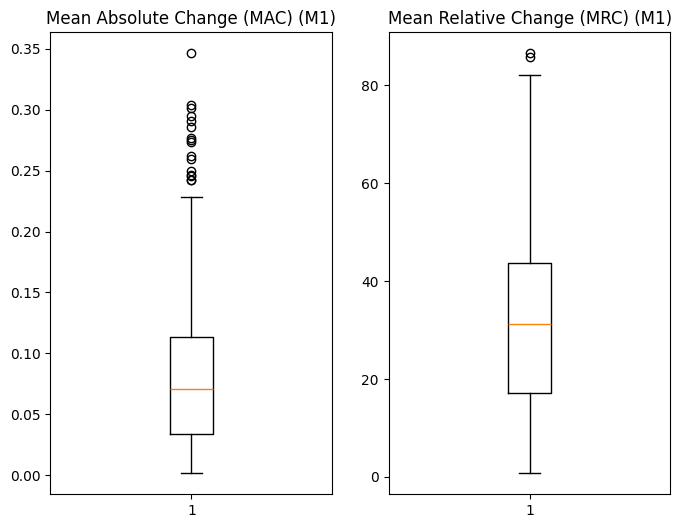

In [486]:
# Plot MAC & MRC on box plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# MAC
ax[0].boxplot((M1_rescheduled_df["mac"]).dropna())
ax[0].set_title("Mean Absolute Change (MAC) (M1)")

# MRC
ax[1].boxplot((M1_rescheduled_df["mrc"]).dropna())
ax[1].set_title("Mean Relative Change (MRC) (M1)")

Avg. lead time change (M1): -141.07803867403314
Median lead time change (M1): -133.0


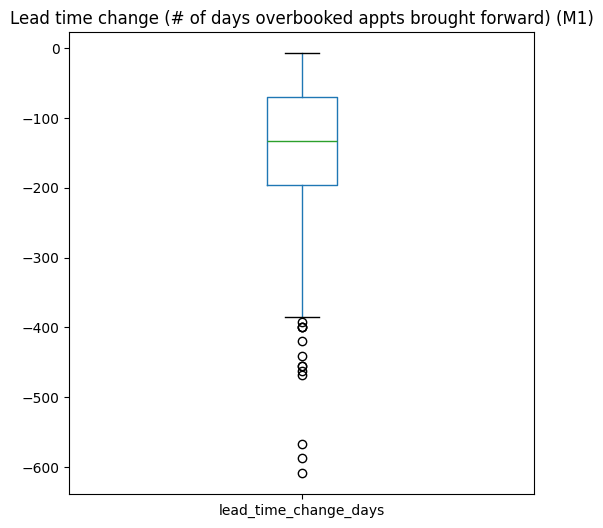

In [487]:
# Calculate the average lead time change
print("Avg. lead time change (M1):", M1_rescheduled_df["lead_time_change_days"].mean())
print("Median lead time change (M1):", M1_rescheduled_df["lead_time_change_days"].median())


# Plot boxplot
M1_rescheduled_df.boxplot(column="lead_time_change_days", figsize=(6, 6), grid=False)
plt.title("Lead time change (# of days overbooked appts brought forward) (M1)")
plt.show()

Mean of weeks waiting reduced (M1): 34.46833070244672
Median of weeks waiting reduced (M1): 32.285714285714285


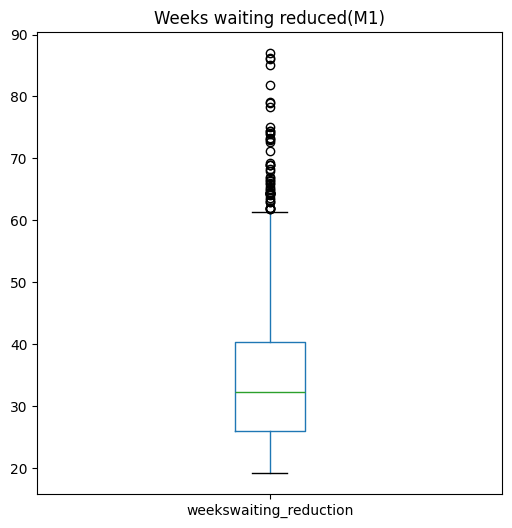

In [488]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
extract_date = pd.to_datetime("2024-04-30")
M1_rescheduled_df["calculated_weekswaiting"] = (M1_rescheduled_df["original_appt_date"] - extract_date).dt.days / 7
M1_rescheduled_df["true_weekswaiting"] = M1_rescheduled_df["weekswaiting"] + M1_rescheduled_df["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
M1_rescheduled_df["weekswaiting_reduction"] = M1_rescheduled_df["true_weekswaiting"] - M1_rescheduled_df["lead_time_change_weeks"].abs()
print("Mean of weeks waiting reduced (M1):", M1_rescheduled_df["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced (M1):", M1_rescheduled_df["weekswaiting_reduction"].median())

# Plot boxplot
M1_rescheduled_df.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(M1)")
plt.show()

### M2: overbook any (other risk levels) into very high risk based on weeks waiting

In [489]:
# # Sort the appointments by weekswaiting (descending; all except the very high risk ones)
# weekswaiting_desc = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)


# Sort the individual appointment durations by weekswaiting (descending; all except the very high risk ones)
weekswaiting_desc_10 = surgeon_new_10[surgeon_new_10["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15 = surgeon_new_15[surgeon_new_15["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20 = surgeon_new_20[surgeon_new_20["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30 = surgeon_new_30[surgeon_new_30["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75 = surgeon_new_75[surgeon_new_75["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)

In [490]:
# Create queues for the "other risk level" appointments
queue10 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time = len(queue10)*10 + len(queue15)*15 + len(queue20)*20 + len(queue30)*30 + len(queue75)*75
print("Sum of starting queue time (M2):", queue_time)

Sum of starting queue time (M2): 32475


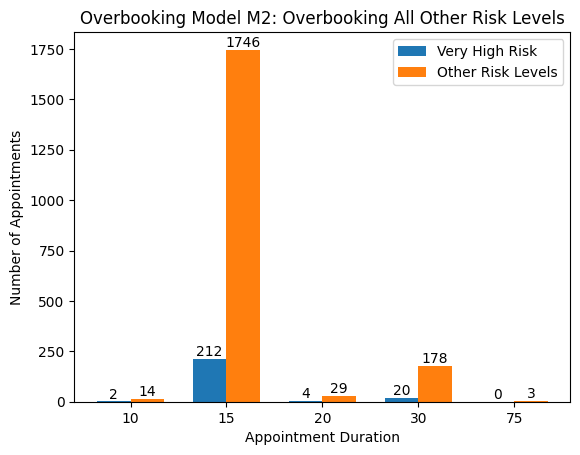

In [491]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10),
    len(queue15),
    len(queue20),
    len(queue30),
    len(queue75),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model M2: Overbooking All Other Risk Levels")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [492]:
# Function to overbook the very high risk appointments
def overbook_appointments(very_high_group, queue):
    overbooked_appointments = []
    for index, very_high_appt in very_high_group.iterrows():
        very_high_date = pd.to_datetime(very_high_appt["appt_date"])
        overbooked = False
        # Create a new, temporary queue to hold appointments that are not suitable for the current very_high_appt for later evaluation
        temp_queue = deque()
        
        while queue:
            # Pop the earliest appointment from the queue
            earliest_appointment_id, earliest_date = queue.popleft()
            # Check if the very_high_date is earlier than the earliest_date
            if very_high_date < earliest_date:
                # Overbook the very high risk slot with the remaining appointment
                overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
                overbooked = True
                break
            else:
                # If the date is not suitable, move the appointment to the temporary queue
                temp_queue.append((earliest_appointment_id, earliest_date))
        
        # Merge the temporary queue back into the original queue
        queue.extendleft(reversed(temp_queue))
        
        if not overbooked:
            # No more appointments to overbook
            overbooked_appointments.append((very_high_appt["appointment_id"], None))
    
    return overbooked_appointments

# Overbook each very high risk appointment duration group
overbooked_10 = overbook_appointments(surgeon_new_very_high_10, queue10)
overbooked_15 = overbook_appointments(surgeon_new_very_high_15, queue15)
overbooked_20 = overbook_appointments(surgeon_new_very_high_20, queue20)
overbooked_30 = overbook_appointments(surgeon_new_very_high_30, queue30)
overbooked_75 = overbook_appointments(surgeon_new_very_high_75, queue75)

# Combine all overbooked results
all_overbooked_appointments = overbooked_10 + overbooked_15 + overbooked_20 + overbooked_30 + overbooked_75

# Convert to DataFrame
overbooked_df = pd.DataFrame(all_overbooked_appointments, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df

,very_high_appt_id,overbooked_appt_id
0,19853208,19971567.0
1,20111728,NaN
2,17671208,17671294.0
3,17901062,17667391.0
4,18011196,20112378.0
...,...,...
233,19938829,20141614.0
234,19971221,19881525.0
235,19972250,20056268.0
236,20055757,20055807.0


In [493]:
# Check if any duplicated overbooked appointments
overbooked_df.dropna(subset=["overbooked_appt_id"])[overbooked_df.dropna(subset=["overbooked_appt_id"]).duplicated("overbooked_appt_id", keep=False)]

,very_high_appt_id,overbooked_appt_id


In [494]:
# Check the funtion works properly by evaluating 10-minute appointments
print(overbooked_10)
print(len(overbooked_10))
print(len(surgeon_new_very_high_10))
print(len(queue10))


[(19853208, 19971567), (20111728, None)]
2
2
13


In [495]:
# Calculate lead time change of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df = pd.merge(overbooked_df, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df = pd.merge(overbooked_df,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "weekswaiting","appt_duration", "lead_time"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting",
                                                                                                                          "lead_time": "overbooked_lead_time"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the lead time change between the original and overbooked appointments
#overbooked_df["lead_time_change_days"] = (pd.to_datetime(overbooked_df["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df["very_high_appt_date"])).dt.days
overbooked_df["lead_time_change_days"] = (pd.to_datetime(overbooked_df["very_high_appt_date"]) - pd.to_datetime(overbooked_df["original_overbooked_appt_date"])).dt.days

# Convert lead_time_change_days into weeks
overbooked_df["lead_time_change_weeks"] = overbooked_df["lead_time_change_days"] / 7

overbooked_df

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,7.0,10.0,317.0,-1.0,-0.142857
1,20111728,NaN,2025-04-02,0.656163,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,59.0,15.0,370.0,-3.0,-0.428571
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,60.0,15.0,368.0,-11.0,-1.571429
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,59.0,15.0,333.0,-288.0,-41.142857
...,...,...,...,...,...,...,...,...,...,...,...
233,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,11.0,30.0,371.0,-21.0,-3.000000
234,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,9.0,30.0,371.0,-9.0,-1.285714
235,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,8.0,30.0,371.0,-56.0,-8.000000
236,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,6.0,30.0,371.0,-14.0,-2.000000


In [496]:
# New DNA risk with reduced lead time (overbooked appts)

# Calculate change in logit
delta_logit_M2 = lead_time_coeff * overbooked_df["lead_time_change_days"]

# Convert original DNA risk score to logit
overbooked_df["original_overbooked_dna_logit"] = logit(overbooked_df["original_overbooked_dna_risk"])

# Calculate the new logit
overbooked_df["new_logit"] = overbooked_df["original_overbooked_dna_logit"] + delta_logit_M2

# Convert the new logit to the new DNA risk score
overbooked_df["new_dna_risk"] = expit(overbooked_df["new_logit"])

overbooked_df


,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks,original_overbooked_dna_logit,new_logit,new_dna_risk
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,7.0,10.0,317.0,-1.0,-0.142857,-0.641482,-0.645138,0.344086
1,20111728,NaN,2025-04-02,0.656163,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,59.0,15.0,370.0,-3.0,-0.428571,-0.760976,-0.771943,0.316059
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,60.0,15.0,368.0,-11.0,-1.571429,-1.036846,-1.077056,0.254063
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,59.0,15.0,333.0,-288.0,-41.142857,-0.965631,-2.018410,0.117283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,11.0,30.0,371.0,-21.0,-3.000000,-1.522867,-1.599632,0.168033
234,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,9.0,30.0,371.0,-9.0,-1.285714,-0.886717,-0.919616,0.285036
235,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,8.0,30.0,371.0,-56.0,-8.000000,-1.129211,-1.333918,0.208512
236,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,6.0,30.0,371.0,-14.0,-2.000000,-0.368990,-0.420167,0.396477


In [497]:
# Calculate MAC & MRC & percentage of appts w/ reduced risk

# MAC
overbooked_df["mac"] = (overbooked_df["new_dna_risk"] - overbooked_df["original_overbooked_dna_risk"]).abs()

# Avg. MAC (mean absolute change)
mac_M2 = (overbooked_df["mac"]).mean()
print("Avg. MAC M2:", mac_M2)

# MRC
overbooked_df["mrc"] = ((overbooked_df["new_dna_risk"] - overbooked_df["original_overbooked_dna_risk"]).abs() / overbooked_df["original_overbooked_dna_risk"])*100

# Avg. MRC (mean relative change)
mrc_M2 = (overbooked_df["mrc"]).mean()
print("Avg. MRC M2:", mrc_M2)

# Calculate the percentage of appointments with reduced risk
rescheduled_appts_M2 = overbooked_df[overbooked_df["new_dna_risk"].notnull()]["new_dna_risk"].nunique()
perc_rescheduled_appts_M2 = (rescheduled_appts_M2 / total_appts) * 100
print("Percentage of appointments with reduced risk (M2):", perc_rescheduled_appts_M2)

Avg. MAC M2: 0.02144817069661317
Avg. MRC M2: 8.390242983840025
Percentage of appointments with reduced risk (M2): 10.733695652173914


Text(0.5, 1.0, 'Mean Relative Change (MRC) (M2)')

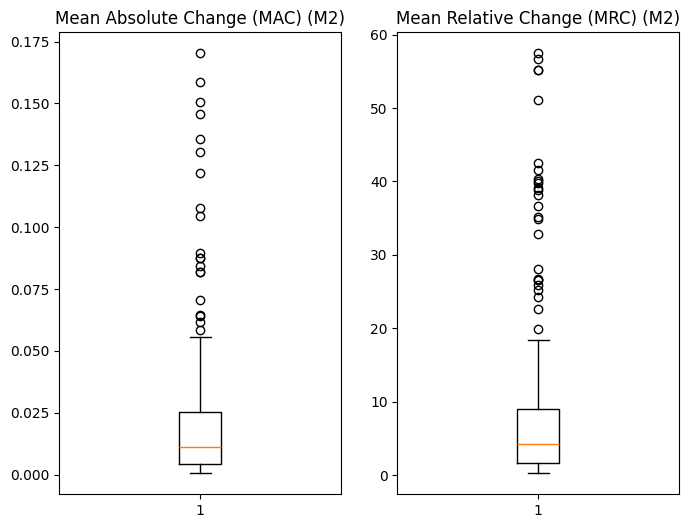

In [498]:
# Plot MAC & MRC on box plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# MAC
ax[0].boxplot((overbooked_df["mac"]).dropna())
ax[0].set_title("Mean Absolute Change (MAC) (M2)")

# MRC
ax[1].boxplot((overbooked_df["mrc"]).dropna())
ax[1].set_title("Mean Relative Change (MRC) (M2)")

Avg. lead time change (M2): -34.59915611814346
Median lead time change (M2): -17.0


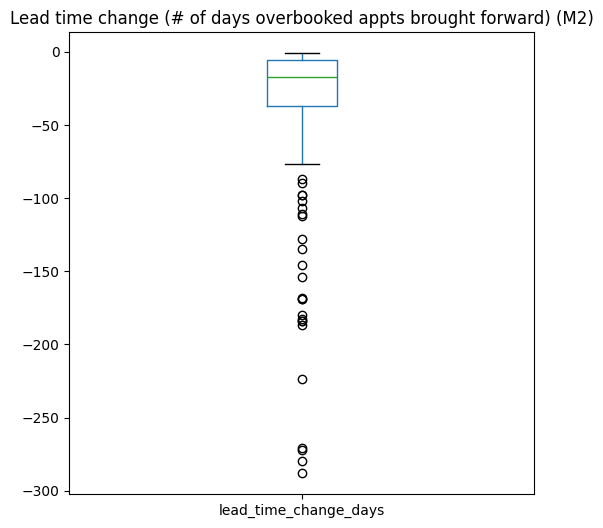

In [499]:
# Calculate the average lead time change
print("Avg. lead time change (M2):", overbooked_df["lead_time_change_days"].mean())
print("Median lead time change (M2):", overbooked_df["lead_time_change_days"].median())


# Plot boxplot
overbooked_df.boxplot(column="lead_time_change_days", figsize=(6, 6), grid=False)
plt.title("Lead time change (# of days overbooked appts brought forward) (M2)")
plt.show()

In [500]:
# Count the remaining appointments in each queue
remaining_10 = len(queue10) * 10
remaining_15 = len(queue15) * 15
remaining_20 = len(queue20) * 20
remaining_30 = len(queue30) * 30
remaining_75 = len(queue75) * 75

# Sum the remaining appointments
remainder_queue_time = remaining_10 + remaining_15 + remaining_20 + remaining_30 + remaining_75
remainder_queue_time

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (M2):", overbooked_df["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (M2):", queue_time - remainder_queue_time)

Sum of overbooked duration (M2): 3870.0
Sum of queue utilised (M2): 3870


Mean joint probability (M2): 0.14231882481340213
Median joint probability (M2): 0.13326389145316372


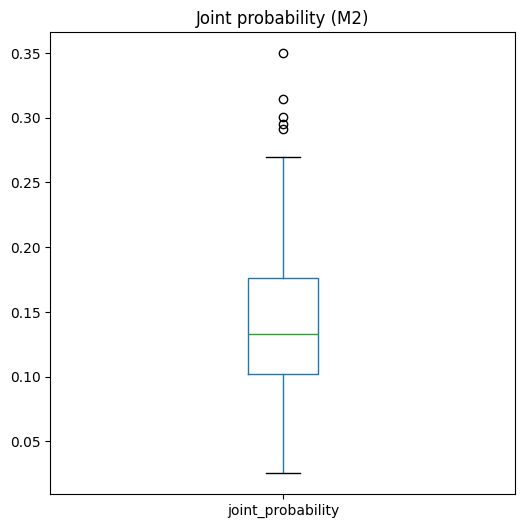

In [501]:
# Calculate probability of clinic overtime
overbooked_df["joint_probability"] = overbooked_df["very_high_dna_risk"] * overbooked_df["new_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (M2):", overbooked_df["joint_probability"].mean())
print("Median joint probability (M2):", overbooked_df["joint_probability"].median())

# Plot boxplot
overbooked_df.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (M2)")
plt.show()


Mean clinic overtime (per appointment scenario) (M2): 4.648465874799118
Median clinic overtime (per appointment scenario) (M2): 4.211951053934613
Spread of clinic overtime (Q3-Q1): 2.5679410000596072


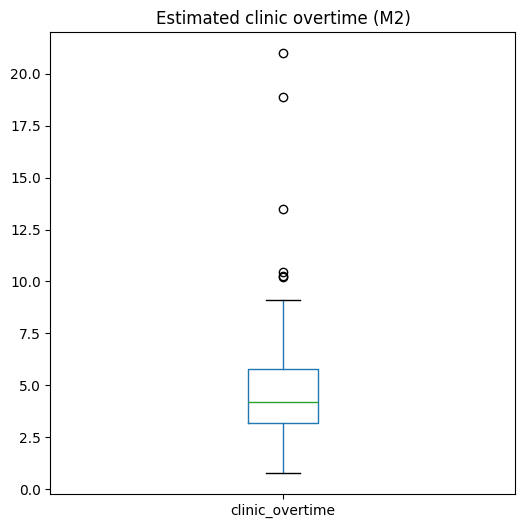

In [502]:
# Calculate estimated clinic overtime
overbooked_df["clinic_overtime"] = overbooked_df["joint_probability"] * (overbooked_df["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (M2):", overbooked_df["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (M2):", overbooked_df["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df["clinic_overtime"].quantile(0.75) - overbooked_df["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (M2)")
plt.show()

Mean of weeks waiting reduced: 63.34538878842678
Median of weeks waiting reduced: 62.42857142857143


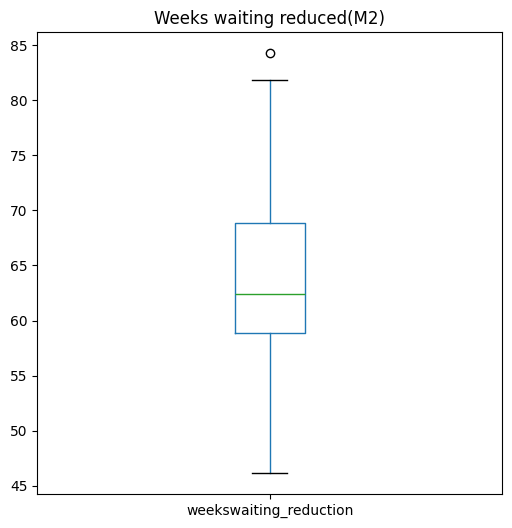

In [503]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
extract_date = pd.to_datetime("2024-04-30")
overbooked_df["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df["true_weekswaiting"] = overbooked_df["original_overbooked_weekswaiting"] + overbooked_df["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df["weekswaiting_reduction"] = overbooked_df["true_weekswaiting"] - overbooked_df["lead_time_change_weeks"].abs()
print("Mean of weeks waiting reduced:", overbooked_df["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(M2)")
plt.show()

### M3: overbook any (other risk levels) into very high risk - using multiple queues

In [504]:
# Create queues for the "other risk level" appointments
queue10_M3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15_M3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20_M3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30_M3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75_M3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_M3 = len(queue10_M3)*10 + len(queue15_M3)*15 + len(queue20_M3)*20 + len(queue30_M3)*30 + len(queue75_M3)*75
print("Sum of starting queue time (M3):", queue_time_M3)

Sum of starting queue time (M3): 32475


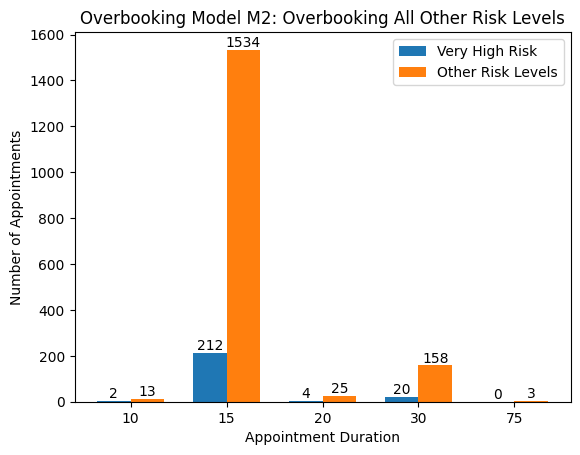

In [505]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10),
    len(queue15),
    len(queue20),
    len(queue30),
    len(queue75),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model M2: Overbooking All Other Risk Levels")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [506]:
# Function to overbook the very high risk appointments - with multiple queues ==> returns same results as appts in queue > # of very high risk appts
def overbook_appointments_multi_queue(very_high_group, queues):
    overbooked_appointments = []
    for index, very_high_appt in very_high_group.iterrows():
        very_high_date = pd.to_datetime(very_high_appt["appt_date"])
        overbooked = False
        for queue in queues:
            temp_queue = deque()  # Temporary queue to hold appointments that are not suitable for the current very_high_appt
            while queue and not overbooked:
                # Pop the earliest appointment from the queue
                earliest_appointment_id, earliest_date = queue.popleft()
                # Check if the very_high_date is earlier than the earliest_date
                if very_high_date < earliest_date:
                    # Overbook the very high risk slot with the remaining appointment
                    overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
                    overbooked = True
                    break
                else:
                    # If the date is not suitable, move the appointment to the temporary queue
                    temp_queue.append((earliest_appointment_id, earliest_date))
            # Merge the temporary queue back into the original queue
            queue.extendleft(reversed(temp_queue))
            if overbooked:
                break
        if not overbooked:
            # No more appointments to overbook
            overbooked_appointments.append((very_high_appt["appointment_id"], None))
    return overbooked_appointments

# Define separate queues by including the "shorter" queues
queues_10 = [queue10_M3]
queues_15 = [queue15_M3, queue10_M3]
queues_20 = [queue20_M3, queue15_M3, queue10_M3]
queues_30 = [queue30_M3, queue20_M3, queue15_M3, queue10_M3]
queues_75 = [queue75_M3, queue30_M3, queue20_M3, queue15_M3, queue10_M3]

# Overbook each very high risk appointment duration group
overbooked_10_M3 = overbook_appointments_multi_queue(surgeon_new_very_high_10, queues_10)
overbooked_15_M3 = overbook_appointments_multi_queue(surgeon_new_very_high_15, queues_15)
overbooked_20_M3 = overbook_appointments_multi_queue(surgeon_new_very_high_20, queues_20)
overbooked_30_M3 = overbook_appointments_multi_queue(surgeon_new_very_high_30, queues_30)
overbooked_75_M3 = overbook_appointments_multi_queue(surgeon_new_very_high_75, queues_75)

# Combine all overbooked results
all_overbooked_appointments_M3 = overbooked_10_M3 + overbooked_15_M3 + overbooked_20_M3 + overbooked_30_M3+ overbooked_75_M3

# Convert to DataFrame
overbooked_df_M3 = pd.DataFrame(all_overbooked_appointments_M3, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df_M3

,very_high_appt_id,overbooked_appt_id
0,19853208,19971567.0
1,20111728,NaN
2,17671208,17671294.0
3,17901062,17667391.0
4,18011196,20112378.0
...,...,...
233,19938829,20141614.0
234,19971221,19881525.0
235,19972250,20056268.0
236,20055757,20055807.0


In [507]:
# Calculate lead time change of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_M3 = pd.merge(overbooked_df_M3, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_M3 = pd.merge(overbooked_df_M3,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "weekswaiting","appt_duration", "lead_time"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting",
                                                                                                                          "lead_time": "overbooked_lead_time"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the lead time change between the original and overbooked appointments
overbooked_df_M3["lead_time_change_days"] = (pd.to_datetime(overbooked_df_M3["very_high_appt_date"]) - pd.to_datetime(overbooked_df_M3["original_overbooked_appt_date"])).dt.days

# Convert lead_time_change_days into weeks
overbooked_df_M3["lead_time_change_weeks"] = overbooked_df_M3["lead_time_change_days"] / 7

overbooked_df_M3

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,7.0,10.0,317.0,-1.0,-0.142857
1,20111728,NaN,2025-04-02,0.656163,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,59.0,15.0,370.0,-3.0,-0.428571
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,60.0,15.0,368.0,-11.0,-1.571429
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,59.0,15.0,333.0,-288.0,-41.142857
...,...,...,...,...,...,...,...,...,...,...,...
233,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,11.0,30.0,371.0,-21.0,-3.000000
234,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,9.0,30.0,371.0,-9.0,-1.285714
235,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,8.0,30.0,371.0,-56.0,-8.000000
236,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,6.0,30.0,371.0,-14.0,-2.000000


In [508]:
# New DNA risk with reduced lead time (overbooked appts)
# # Lead time coefficient is 0.0.003655484 (effect on DNA risk score)

# Calculate change in logit
delta_logit_M3 = lead_time_coeff * overbooked_df_M3["lead_time_change_days"]

# Convert original DNA risk score to logit
overbooked_df_M3["original_overbooked_dna_logit"] = logit(overbooked_df_M3["original_overbooked_dna_risk"])

# Calculate the new logit
overbooked_df_M3["new_logit"] = overbooked_df_M3["original_overbooked_dna_logit"] + delta_logit_M3

# Convert the new logit to the new DNA risk score
overbooked_df_M3["new_dna_risk"] = expit(overbooked_df_M3["new_logit"])

overbooked_df_M3


,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks,original_overbooked_dna_logit,new_logit,new_dna_risk
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,7.0,10.0,317.0,-1.0,-0.142857,-0.641482,-0.645138,0.344086
1,20111728,NaN,2025-04-02,0.656163,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,59.0,15.0,370.0,-3.0,-0.428571,-0.760976,-0.771943,0.316059
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,60.0,15.0,368.0,-11.0,-1.571429,-1.036846,-1.077056,0.254063
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,59.0,15.0,333.0,-288.0,-41.142857,-0.965631,-2.018410,0.117283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,11.0,30.0,371.0,-21.0,-3.000000,-1.522867,-1.599632,0.168033
234,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,9.0,30.0,371.0,-9.0,-1.285714,-0.886717,-0.919616,0.285036
235,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,8.0,30.0,371.0,-56.0,-8.000000,-1.129211,-1.333918,0.208512
236,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,6.0,30.0,371.0,-14.0,-2.000000,-0.368990,-0.420167,0.396477


In [509]:
# Calculate MAC & MRC & percentage of appts w/ reduced risk

# MAC
overbooked_df_M3["mac"] = (overbooked_df_M3["new_dna_risk"] - overbooked_df_M3["original_overbooked_dna_risk"]).abs()

# Avg. MAC (mean absolute change)
mac_M3 = (overbooked_df_M3["mac"]).mean()
print("Avg. MAC M3:", mac_M3)

# MRC
overbooked_df_M3["mrc"] = ((overbooked_df_M3["new_dna_risk"] - overbooked_df_M3["original_overbooked_dna_risk"]).abs() / overbooked_df_M3["original_overbooked_dna_risk"])*100

# Avg. MRC (mean relative change)
mrc_M3 = (overbooked_df_M3["mrc"]).mean()
print("Avg. MRC M3:", mrc_M3)

# Calculate the percentage of appointments with reduced risk
rescheduled_appts_M3 = overbooked_df_M3[overbooked_df_M3["new_dna_risk"].notnull()]["new_dna_risk"].nunique()
perc_rescheduled_appts_M3 = (rescheduled_appts_M3 / total_appts) * 100
print("Percentage of appointments with reduced risk (M3):", perc_rescheduled_appts_M3)


Avg. MAC M3: 0.02144817069661317
Avg. MRC M3: 8.390242983840025
Percentage of appointments with reduced risk (M3): 10.733695652173914


Text(0.5, 1.0, 'Mean Relative Change (MRC) (M3)')

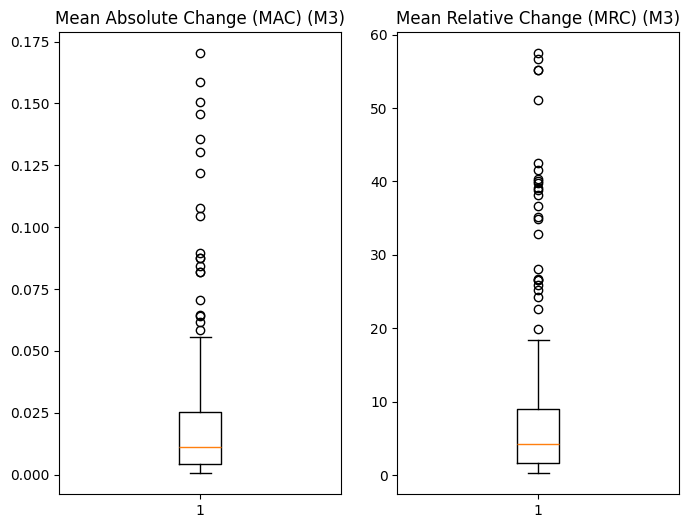

In [510]:
# Plot MAC & MRC on box plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# MAC
ax[0].boxplot((overbooked_df_M3["mac"]).dropna())
ax[0].set_title("Mean Absolute Change (MAC) (M3)")

# MRC
ax[1].boxplot((overbooked_df_M3["mrc"]).dropna())
ax[1].set_title("Mean Relative Change (MRC) (M3)")

Avg. lead time change (M3): -34.59915611814346
Median lead time change (M3): -17.0


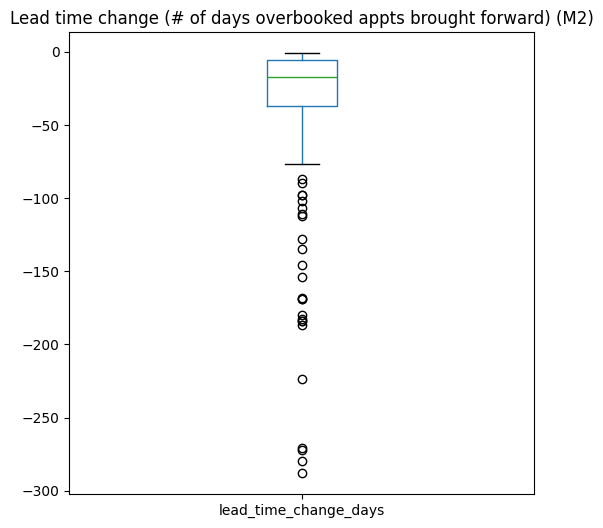

In [511]:
# Calculate the average lead time change
print("Avg. lead time change (M3):", overbooked_df_M3["lead_time_change_days"].mean())
print("Median lead time change (M3):", overbooked_df_M3["lead_time_change_days"].median())


# Plot boxplot
overbooked_df_M3.boxplot(column="lead_time_change_days", figsize=(6, 6), grid=False)
plt.title("Lead time change (# of days overbooked appts brought forward) (M2)")
plt.show()

In [512]:
# Count the remaining appointments in each queue
remaining_10_M3 = len(queue10_M3) * 10
remaining_15_M3 = len(queue15_M3) * 15
remaining_20_M3 = len(queue20_M3) * 20
remaining_30_M3 = len(queue30_M3) * 30
remaining_75_M3 = len(queue75_M3) * 75

# Sum the remaining appointments
remainder_queue_time_M3 = remaining_10_M3 + remaining_15_M3 + remaining_20_M3 + remaining_30_M3 + remaining_75_M3
remainder_queue_time_M3

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (M3):", overbooked_df_M3["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (M3):", queue_time_M3 - remainder_queue_time_M3)

Sum of overbooked duration (M3): 3870.0
Sum of queue utilised (M3): 3870


Mean joint probability (M3): 0.14231882481340213
Median joint probability (M3): 0.13326389145316372


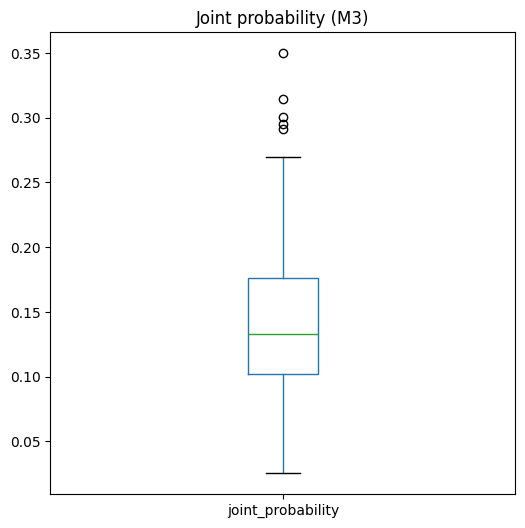

In [513]:
# Calculate probability of clinic overtime
overbooked_df_M3["joint_probability"] = overbooked_df_M3["very_high_dna_risk"] * overbooked_df_M3["new_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (M3):", overbooked_df_M3["joint_probability"].mean())
print("Median joint probability (M3):", overbooked_df_M3["joint_probability"].median())

# Plot boxplot
overbooked_df_M3.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (M3)")
plt.show()


Mean clinic overtime (per appointment scenario) (M3): 4.648465874799118
Median clinic overtime (per appointment scenario) (M3): 4.211951053934613
Spread of clinic overtime (Q3-Q1): 2.5679410000596072


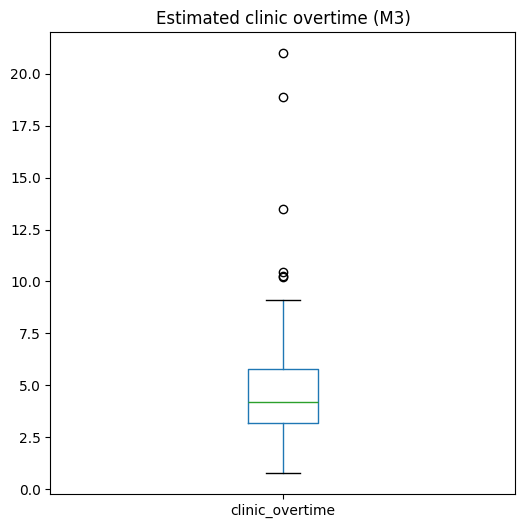

In [514]:
# Calculate estimated clinic overtime
overbooked_df_M3["clinic_overtime"] = overbooked_df_M3["joint_probability"] * (overbooked_df_M3["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (M3):", overbooked_df_M3["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (M3):", overbooked_df_M3["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df_M3["clinic_overtime"].quantile(0.75) - overbooked_df_M3["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df_M3.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (M3)")
plt.show()

Mean of weeks waiting reduced: 63.34538878842678
Median of weeks waiting reduced: 62.42857142857143


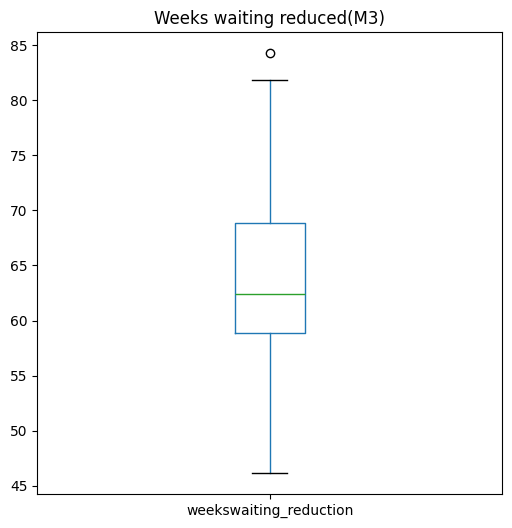

In [515]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
overbooked_df_M3["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df_M3["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df_M3["true_weekswaiting"] = overbooked_df_M3["original_overbooked_weekswaiting"] + overbooked_df_M3["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df_M3["weekswaiting_reduction"] = overbooked_df_M3["true_weekswaiting"] - overbooked_df_M3["lead_time_change_weeks"].abs()
print("Mean of weeks waiting reduced:", overbooked_df_M3["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df_M3["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df_M3.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(M3)")
plt.show()

### V3: overbook low & moderate risks into very high risk based on weeks waiting

In [516]:
# Sort the individual appointment durations by weekswaiting (low & moderate risk)
weekswaiting_desc_10_M4 = surgeon_new_10[(surgeon_new_10["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_10["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15_M4 = surgeon_new_15[(surgeon_new_15["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_15["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20_M4 = surgeon_new_20[(surgeon_new_20["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_20["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30_M4 = surgeon_new_30[(surgeon_new_30["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_30["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75_M4 = surgeon_new_75[(surgeon_new_75["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_75["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)

# Create queues for the "other risk level" appointments
queue10_M4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10_M4[["appointment_id", "appt_date"]].values.tolist()])
queue15_M4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15_M4[["appointment_id", "appt_date"]].values.tolist()])
queue20_M4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20_M4[["appointment_id", "appt_date"]].values.tolist()])
queue30_M4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30_M4[["appointment_id", "appt_date"]].values.tolist()])
queue75_M4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75_M4[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_M4 = len(queue10_M4)*10 + len(queue15_M4)*15 + len(queue20_M4)*20 + len(queue30_M4)*30 + len(queue75_M4)*75
print("Sum of starting queue time (M4):", queue_time_M4)




Sum of starting queue time (M4): 8880


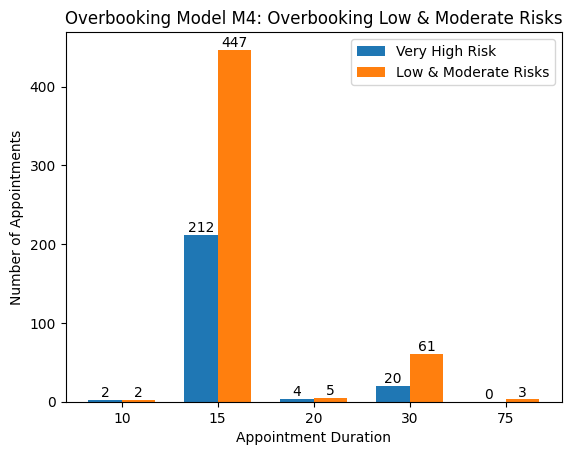

In [517]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10_M4),
    len(queue15_M4),
    len(queue20_M4),
    len(queue30_M4),
    len(queue75_M4),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Low & Moderate Risks")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model M4: Overbooking Low & Moderate Risks")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [518]:
# Overbook each very high risk appointment duration group by using the same overbooking function as M2
overbooked_10_M4 = overbook_appointments(surgeon_new_very_high_10, queue10_M4)
overbooked_15_M4 = overbook_appointments(surgeon_new_very_high_15, queue15_M4)
overbooked_20_M4 = overbook_appointments(surgeon_new_very_high_20, queue20_M4)
overbooked_30_M4 = overbook_appointments(surgeon_new_very_high_30, queue30_M4)
overbooked_75_M4 = overbook_appointments(surgeon_new_very_high_75, queue75_M4)

# Combine all overbooked results
all_overbooked_appointments_M4 = overbooked_10_M4 + overbooked_15_M4 + overbooked_20_M4 + overbooked_30_M4 + overbooked_75_M4

# Convert to DataFrame
overbooked_df_M4 = pd.DataFrame(all_overbooked_appointments_M4, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df_M4



,very_high_appt_id,overbooked_appt_id
0,19853208,NaN
1,20111728,NaN
2,17671208,20026346.0
3,17901062,20026219.0
4,18011196,20025984.0
...,...,...
233,19938829,NaN
234,19971221,NaN
235,19972250,NaN
236,20055757,NaN


In [519]:
# Calculate lead time change of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_M4 = pd.merge(overbooked_df_M4, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                         "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_M4 = pd.merge(overbooked_df_M4,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "weekswaiting", "appt_duration", "lead_time"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting",
                                                                                                                          "lead_time": "overbooked_lead_time"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the lead time change between the original and overbooked appointments
overbooked_df_M4["lead_time_change_days"] = (pd.to_datetime(overbooked_df_M4["very_high_appt_date"]) - pd.to_datetime(overbooked_df_M4["original_overbooked_appt_date"])).dt.days

# Convert lead_time_change_days into weeks
overbooked_df_M4["lead_time_change_weeks"] = overbooked_df_M4["lead_time_change_days"] / 7

overbooked_df_M4

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks
0,19853208,NaN,2025-01-29,0.619074,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,20111728,NaN,2025-04-02,0.656163,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,20026346.0,2024-05-20,0.710675,2024-08-27,0.061545,54.0,15.0,154.0,-99.0,-14.142857
3,17901062,20026219.0,2024-05-09,0.455411,2025-01-15,0.175142,53.0,15.0,295.0,-251.0,-35.857143
4,18011196,20025984.0,2024-05-23,0.775510,2024-08-20,0.081328,48.0,15.0,147.0,-89.0,-12.714286
...,...,...,...,...,...,...,...,...,...,...,...
233,19938829,NaN,2025-04-15,0.473121,NaT,NaN,NaN,NaN,NaN,NaN,NaN
234,19971221,NaN,2025-04-15,0.489043,NaT,NaN,NaN,NaN,NaN,NaN,NaN
235,19972250,NaN,2025-05-29,0.461040,NaT,NaN,NaN,NaN,NaN,NaN,NaN
236,20055757,NaN,2025-07-03,0.793514,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [520]:
# New DNA risk with reduced lead time (overbooked appts)
# # Lead time coefficient is 0.0.003655484 (effect on DNA risk score)

# Calculate change in logit
delta_logit_M4 = lead_time_coeff * overbooked_df_M4["lead_time_change_days"]

# Convert original DNA risk score to logit
overbooked_df_M4["original_overbooked_dna_logit"] = logit(overbooked_df_M4["original_overbooked_dna_risk"])

# Calculate the new logit
overbooked_df_M4["new_logit"] = overbooked_df_M4["original_overbooked_dna_logit"] + delta_logit_M4

# Convert the new logit to the new DNA risk score
overbooked_df_M4["new_dna_risk"] = expit(overbooked_df_M4["new_logit"])

overbooked_df_M4


,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks,original_overbooked_dna_logit,new_logit,new_dna_risk
0,19853208,NaN,2025-01-29,0.619074,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20111728,NaN,2025-04-02,0.656163,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,20026346.0,2024-05-20,0.710675,2024-08-27,0.061545,54.0,15.0,154.0,-99.0,-14.142857,-2.724472,-3.086365,0.043673
3,17901062,20026219.0,2024-05-09,0.455411,2025-01-15,0.175142,53.0,15.0,295.0,-251.0,-35.857143,-1.549613,-2.467139,0.078194
4,18011196,20025984.0,2024-05-23,0.775510,2024-08-20,0.081328,48.0,15.0,147.0,-89.0,-12.714286,-2.424438,-2.749776,0.060099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,19938829,NaN,2025-04-15,0.473121,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,19971221,NaN,2025-04-15,0.489043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,19972250,NaN,2025-05-29,0.461040,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,20055757,NaN,2025-07-03,0.793514,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [521]:
# Calculate MAC & MRC & percentage of appts w/ reduced risk

# MAC
overbooked_df_M4["mac"] = (overbooked_df_M4["new_dna_risk"] - overbooked_df_M4["original_overbooked_dna_risk"]).abs()

# Avg. MAC (mean absolute change)
mac_M4 = (overbooked_df_M4["mac"]).mean()
print("Avg. MAC M4:", mac_M4)

# MRC
overbooked_df_M4["mrc"] = ((overbooked_df_M4["new_dna_risk"] - overbooked_df_M4["original_overbooked_dna_risk"]).abs() / overbooked_df_M4["original_overbooked_dna_risk"])*100

# Avg. MRC (mean relative change)
mrc_M4 = (overbooked_df_M4["mrc"]).mean()
print("Avg. MRC M4:", mrc_M4)

# Calculate the percentage of appointments with reduced risk
rescheduled_appts_M4 = overbooked_df_M4[overbooked_df_M4["new_dna_risk"].notnull()]["new_dna_risk"].nunique()
perc_rescheduled_appts_M4 = (rescheduled_appts_M4 / total_appts) * 100
print("Percentage of appointments with reduced risk (M4):", perc_rescheduled_appts_M4)


Avg. MAC M4: 0.011386960764933573
Avg. MRC M4: 7.4635230430383315
Percentage of appointments with reduced risk (M4): 9.918478260869565


Text(0.5, 1.0, 'Mean Relative Change (MRC) (M4)')

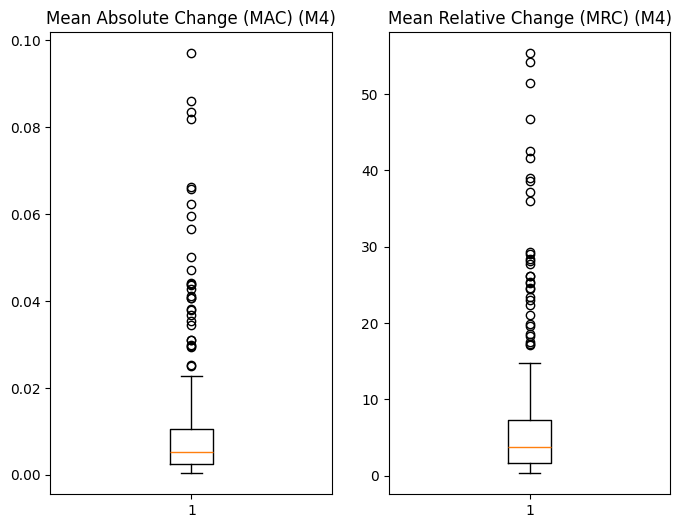

In [522]:
# Plot MAC & MRC on box plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# MAC
ax[0].boxplot((overbooked_df_M4["mac"]).dropna())
ax[0].set_title("Mean Absolute Change (MAC) (M4)")

# MRC
ax[1].boxplot((overbooked_df_M4["mrc"]).dropna())
ax[1].set_title("Mean Relative Change (MRC) (M4)")

Avg. lead time change (M4): -27.114155251141554
Median lead time change (M4): -12.0


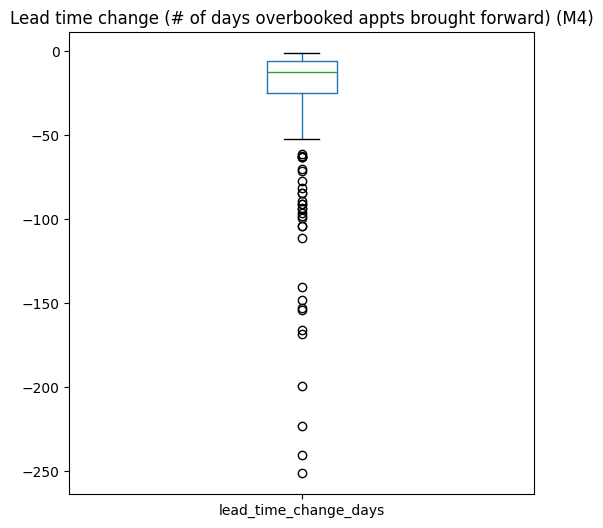

In [523]:
# Calculate the average & median lead time change
print("Avg. lead time change (M4):", overbooked_df_M4["lead_time_change_days"].mean())
print("Median lead time change (M4):", overbooked_df_M4["lead_time_change_days"].median())


# Plot boxplot
overbooked_df_M4.boxplot(column="lead_time_change_days", figsize=(6, 6), grid=False)
plt.title("Lead time change (# of days overbooked appts brought forward) (M4)")
plt.show()

In [524]:
# Count the remaining appointments in each queue
remaining_10_M4 = len(queue10_M4) * 10
remaining_15_M4 = len(queue15_M4) * 15
remaining_20_M4 = len(queue20_M4) * 20
remaining_30_M4 = len(queue30_M4) * 30
remaining_75_M4 = len(queue75_M4) * 75

# Sum the remaining appointments
remainder_queue_time_M4 = remaining_10_M4 + remaining_15_M4 + remaining_20_M4 + remaining_30_M4 + remaining_75_M4
remainder_queue_time_M4

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (M4):", overbooked_df_M4["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (M4):", queue_time_M4 - remainder_queue_time_M4)

Sum of overbooked duration (M4): 3525.0
Sum of queue utilised (M4): 3525


Mean joint probability (M4): 0.0795038961829366
Median joint probability (M4): 0.07653395382275921


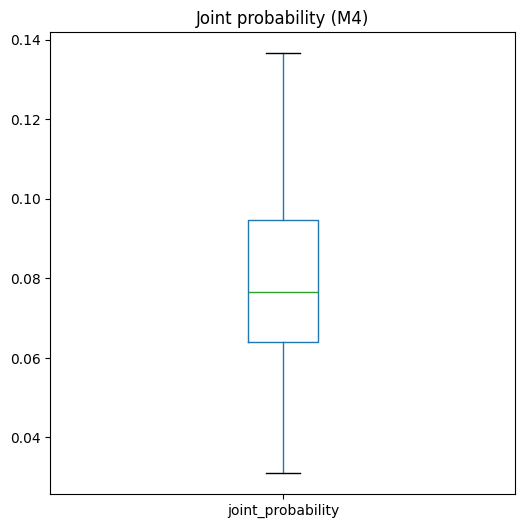

In [525]:
# Calculate probability of clinic overtime
overbooked_df_M4["joint_probability"] = overbooked_df_M4["very_high_dna_risk"] * overbooked_df_M4["new_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (M4):", overbooked_df_M4["joint_probability"].mean())
print("Median joint probability (M4):", overbooked_df_M4["joint_probability"].median())

# Plot boxplot
overbooked_df_M4.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (M4)")
plt.show()

Mean clinic overtime (per appointment scenario) (M4): 2.57567107807966
Median clinic overtime (per appointment scenario) (M4): 2.3485036632042764
Spread of clinic overtime (Q3-Q1): 0.949388924349654


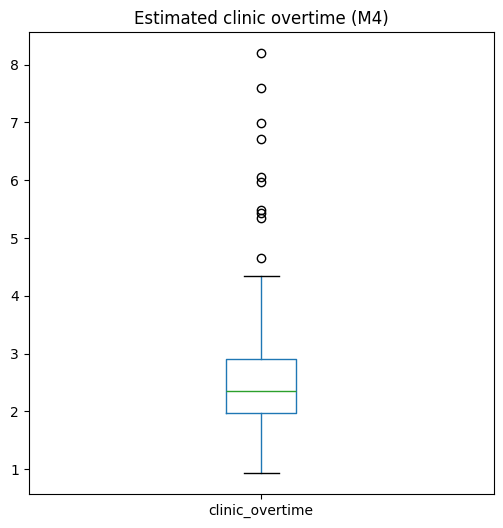

In [526]:
# Calculate estimated clinic overtime
overbooked_df_M4["clinic_overtime"] = overbooked_df_M4["joint_probability"] * (overbooked_df_M4["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (M4):", overbooked_df_M4["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (M4):", overbooked_df_M4["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df_M4["clinic_overtime"].quantile(0.75) - overbooked_df_M4["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df_M4.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (M4)")
plt.show()

Mean of weeks waiting reduced: 52.89041095890411
Median of weeks waiting reduced: 50.28571428571428


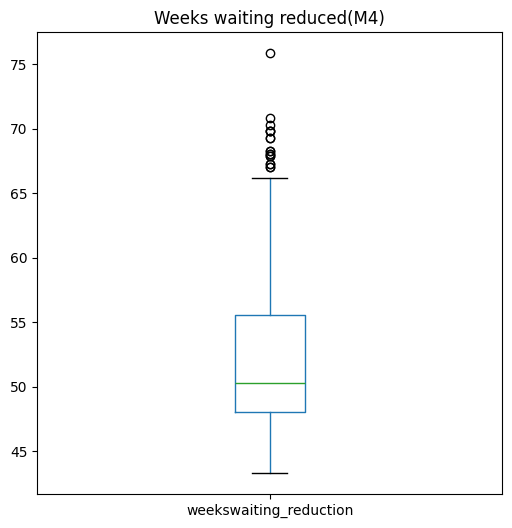

In [527]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
overbooked_df_M4["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df_M4["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df_M4["true_weekswaiting"] = overbooked_df_M4["original_overbooked_weekswaiting"] + overbooked_df_M4["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df_M4["weekswaiting_reduction"] = overbooked_df_M4["true_weekswaiting"] - overbooked_df_M4["lead_time_change_weeks"].abs()
print("Mean of weeks waiting reduced:", overbooked_df_M4["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df_M4["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df_M4.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(M4)")
plt.show()

### M5: under-overbook (eg. overbook a 20min in a 30min slot) to avoid clinic overtime; low + moderate + high

In [528]:
# Using the same queues and function as M2
# Recreate the queues for the "other risk level" appointments
queue10_M5 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15_M5 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20_M5 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30_M5 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75_M5 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_M5 = len(queue10_M5)*10 + len(queue15_M5)*15 + len(queue20_M5)*20 + len(queue30_M5)*30 + len(queue75_M5)*75
print("Sum of starting queue time (M5):", queue_time_M5)

Sum of starting queue time (M5): 32475


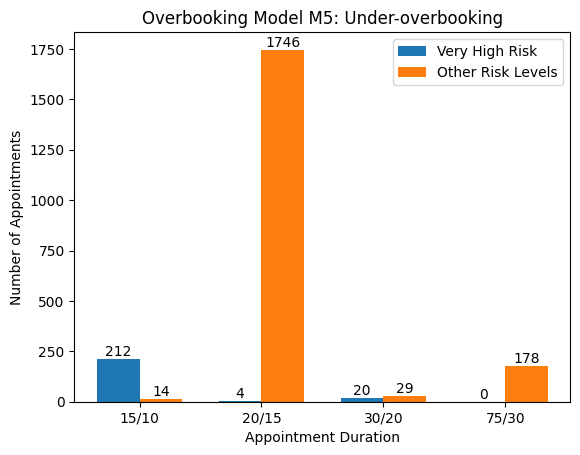

In [529]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    # len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10_M5),
    len(queue15_M5),
    len(queue20_M5),
    len(queue30_M5),
    # len(queue75_M5),
]

# Define the durations
durations = ["15/10", "20/15", "30/20", "75/30"]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model M5: Under-overbooking")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [530]:
# Overbook each very high risk appointment duration group
# Not possible for 10-minute appiontments as no shorter duration appointments available
overbooked_15_M5 = overbook_appointments(surgeon_new_very_high_15, queue10_M5)
overbooked_20_M5 = overbook_appointments(surgeon_new_very_high_20, queue15_M5)
overbooked_30_M5 = overbook_appointments(surgeon_new_very_high_30, queue20_M5)
overbooked_75_M5 = overbook_appointments(surgeon_new_very_high_75, queue30_M5)

# Combine all overbooked results
all_overbooked_appointments_M5 = overbooked_15_M5 + overbooked_20_M5 + overbooked_30_M5 + overbooked_75_M5

# Convert to DataFrame
overbooked_df_M5 = pd.DataFrame(all_overbooked_appointments_M5, columns=["very_high_appt_id", "overbooked_appt_id"])

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_M5 = pd.merge(overbooked_df_M5, 
                            data[["appointment_id", "appt_date", "appt_duration" ,"did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "appt_duration": "very_high_appt_duration",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_M5 = pd.merge(overbooked_df_M5,
                            data[["appointment_id", "appt_date", "appt_duration", "did_not_attend_risk", "weekswaiting", "lead_time"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "appt_duration": "original_overbooked_appt_duration",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting",
                                                                                                                          "lead_time": "overbooked_lead_time"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])


# Calculate the lead time change between the original and overbooked appointments
overbooked_df_M5["lead_time_change_days"] = (pd.to_datetime(overbooked_df_M5["very_high_appt_date"]) - pd.to_datetime(overbooked_df_M5["original_overbooked_appt_date"])).dt.days

# Convert lead_time_change_days into weeks
overbooked_df_M5["lead_time_change_weeks"] = overbooked_df_M5["lead_time_change_days"] / 7

overbooked_df_M5

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_appt_duration,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_appt_duration,original_overbooked_dna_risk,original_overbooked_weekswaiting,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks
0,17671208,18616180.0,2024-05-20,15.0,0.710675,2024-06-20,10.0,0.384087,42.0,272.0,-31.0,-4.428571
1,17901062,18296387.0,2024-05-09,15.0,0.455411,2024-07-10,10.0,0.246540,38.0,335.0,-62.0,-8.857143
2,18011196,18748587.0,2024-05-23,15.0,0.775510,2024-08-12,10.0,0.209423,29.0,306.0,-81.0,-11.571429
3,18012765,18867602.0,2024-05-02,15.0,0.574464,2024-09-11,10.0,0.241837,27.0,321.0,-132.0,-18.857143
4,18017248,19268866.0,2024-05-29,15.0,0.582589,2024-09-30,10.0,0.243421,21.0,290.0,-124.0,-17.714286
...,...,...,...,...,...,...,...,...,...,...,...,...
231,19938829,19664457.0,2025-04-15,30.0,0.473121,2025-07-07,20.0,0.257243,15.0,371.0,-83.0,-11.857143
232,19971221,19664473.0,2025-04-15,30.0,0.489043,2025-07-14,20.0,0.277879,15.0,371.0,-90.0,-12.857143
233,19972250,19517889.0,2025-05-29,30.0,0.461040,2025-06-09,20.0,0.413918,15.0,371.0,-11.0,-1.571429
234,20055757,19826747.0,2025-07-03,30.0,0.793514,2025-08-18,20.0,0.312378,12.0,371.0,-46.0,-6.571429


In [531]:
# New DNA risk with reduced lead time (overbooked appts)
# # Lead time coefficient is 0.0.003655484 (effect on DNA risk score)

# Calculate change in logit
delta_logit_M5 = lead_time_coeff * overbooked_df_M5["lead_time_change_days"]

# Convert original DNA risk score to logit
overbooked_df_M5["original_overbooked_dna_logit"] = logit(overbooked_df_M5["original_overbooked_dna_risk"])

# Calculate the new logit
overbooked_df_M5["new_logit"] = overbooked_df_M5["original_overbooked_dna_logit"] + delta_logit_M5

# Convert the new logit to the new DNA risk score
overbooked_df_M5["new_dna_risk"] = expit(overbooked_df_M5["new_logit"])

overbooked_df_M5


,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_appt_duration,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_appt_duration,original_overbooked_dna_risk,original_overbooked_weekswaiting,overbooked_lead_time,lead_time_change_days,lead_time_change_weeks,original_overbooked_dna_logit,new_logit,new_dna_risk
0,17671208,18616180.0,2024-05-20,15.0,0.710675,2024-06-20,10.0,0.384087,42.0,272.0,-31.0,-4.428571,-0.472236,-0.585556,0.357655
1,17901062,18296387.0,2024-05-09,15.0,0.455411,2024-07-10,10.0,0.246540,38.0,335.0,-62.0,-8.857143,-1.117149,-1.343789,0.206888
2,18011196,18748587.0,2024-05-23,15.0,0.775510,2024-08-12,10.0,0.209423,29.0,306.0,-81.0,-11.571429,-1.328410,-1.624504,0.164585
3,18012765,18867602.0,2024-05-02,15.0,0.574464,2024-09-11,10.0,0.241837,27.0,321.0,-132.0,-18.857143,-1.142634,-1.625158,0.164495
4,18017248,19268866.0,2024-05-29,15.0,0.582589,2024-09-30,10.0,0.243421,21.0,290.0,-124.0,-17.714286,-1.134016,-1.587296,0.169765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,19938829,19664457.0,2025-04-15,30.0,0.473121,2025-07-07,20.0,0.257243,15.0,371.0,-83.0,-11.857143,-1.060348,-1.363753,0.203631
232,19971221,19664473.0,2025-04-15,30.0,0.489043,2025-07-14,20.0,0.277879,15.0,371.0,-90.0,-12.857143,-0.955007,-1.284000,0.216870
233,19972250,19517889.0,2025-05-29,30.0,0.461040,2025-06-09,20.0,0.413918,15.0,371.0,-11.0,-1.571429,-0.347793,-0.388003,0.404198
234,20055757,19826747.0,2025-07-03,30.0,0.793514,2025-08-18,20.0,0.312378,12.0,371.0,-46.0,-6.571429,-0.789026,-0.957179,0.277443


In [532]:
# Calculate MAC & MRC & percentage of appts w/ reduced risk

# MAC
overbooked_df_M5["mac"] = (overbooked_df_M5["new_dna_risk"] - overbooked_df_M5["original_overbooked_dna_risk"]).abs()

# Avg. MAC (mean absolute change)
mac_M5 = (overbooked_df_M5["mac"]).mean()
print("Avg. MAC M5:", mac_M5)

# MRC
overbooked_df_M5["mrc"] = ((overbooked_df_M5["new_dna_risk"] - overbooked_df_M5["original_overbooked_dna_risk"]).abs() / overbooked_df_M5["original_overbooked_dna_risk"])*100

# Avg. MRC (mean relative change)
mrc_M5 = (overbooked_df_M5["mrc"]).mean()
print("Avg. MRC M5:", mrc_M5)

# Calculate the percentage of appointments with reduced risk
rescheduled_appts_M5 = overbooked_df_M5[overbooked_df_M5["new_dna_risk"].notnull()]["new_dna_risk"].nunique()
perc_rescheduled_appts_M5 = (rescheduled_appts_M5 / total_appts) * 100
print("Percentage of appointments with reduced risk (M5):", perc_rescheduled_appts_M5)


Avg. MAC M5: 0.06564740140730162
Avg. MRC M5: 24.24432610913572
Percentage of appointments with reduced risk (M5): 1.7210144927536233


Text(0.5, 1.0, 'Mean Relative Change (MRC) (M5)')

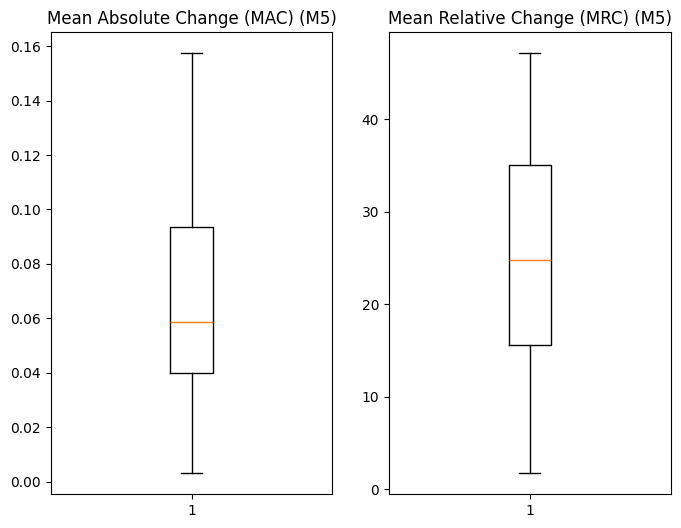

In [533]:
# Plot MAC & MRC on box plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# MAC
ax[0].boxplot((overbooked_df_M5["mac"]).dropna())
ax[0].set_title("Mean Absolute Change (MAC) (M5)")

# MRC
ax[1].boxplot((overbooked_df_M5["mrc"]).dropna())
ax[1].set_title("Mean Relative Change (MRC) (M5)")

Avg. lead time change (M5): -103.94736842105263
Median lead time change (M5): -99.5


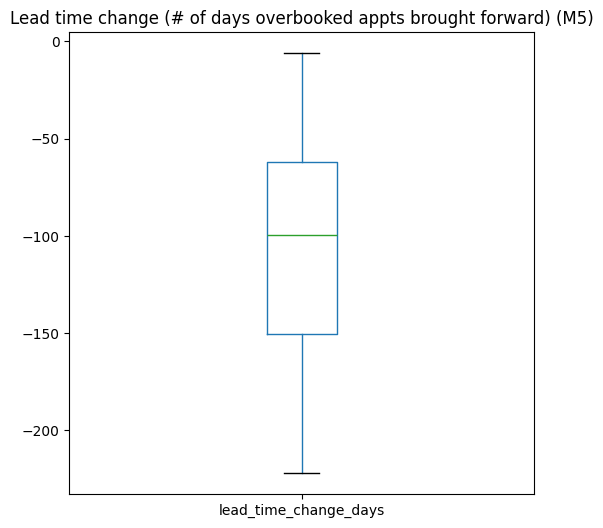

In [534]:
# Calculate the average lead time change
print("Avg. lead time change (M5):", overbooked_df_M5["lead_time_change_days"].mean())
print("Median lead time change (M5):", overbooked_df_M5["lead_time_change_days"].median())


# Plot boxplot
overbooked_df_M5.boxplot(column="lead_time_change_days", figsize=(6, 6), grid=False)
plt.title("Lead time change (# of days overbooked appts brought forward) (M5)")
plt.show()

In [535]:
# Count the remaining appointments in each queue
remaining_10_M5 = len(queue10_M5) * 10
remaining_15_M5 = len(queue15_M5) * 15
remaining_20_M5 = len(queue20_M5) * 20
remaining_30_M5 = len(queue30_M5) * 30
remaining_75_M5 = len(queue75_M5) * 75

# Sum the remaining appointments
remainder_queue_time_M5 = remaining_10_M5 + remaining_15_M5 + remaining_20_M5 + remaining_30_M5 + remaining_75_M5
remainder_queue_time_M5

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (M5):", overbooked_df_M5["original_overbooked_appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (M5):", queue_time_M5 - remainder_queue_time_M5)

Sum of overbooked duration (M5): 600.0
Sum of queue utilised (M5): 600


Mean joint probability (M5): 0.12079834814799331
Median joint probability (M5): 0.10647976623491065


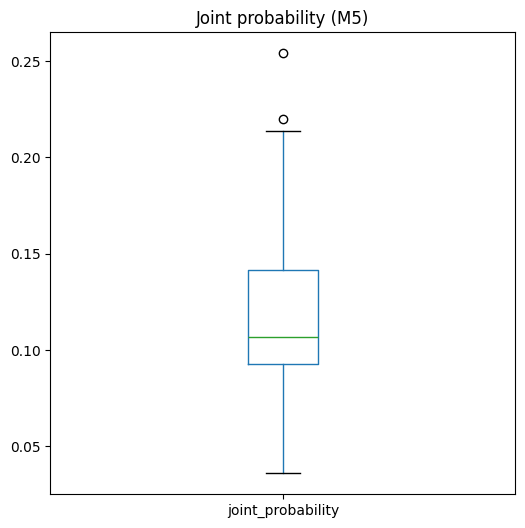

In [536]:
# Calculate probability of clinic overtime
overbooked_df_M5["joint_probability"] = overbooked_df_M5["very_high_dna_risk"] * overbooked_df_M5["new_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (M5):", overbooked_df_M5["joint_probability"].mean())
print("Median joint probability (M5):", overbooked_df_M5["joint_probability"].median())

# Plot boxplot
overbooked_df_M5.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (M5)")
plt.show()

Mean clinic overtime (per appointment scenario) (M5): 4.9265984668284135
Median clinic overtime (per appointment scenario) (M5): 4.311257732166519
Spread of clinic overtime (Q3-Q1): 3.905712191139166


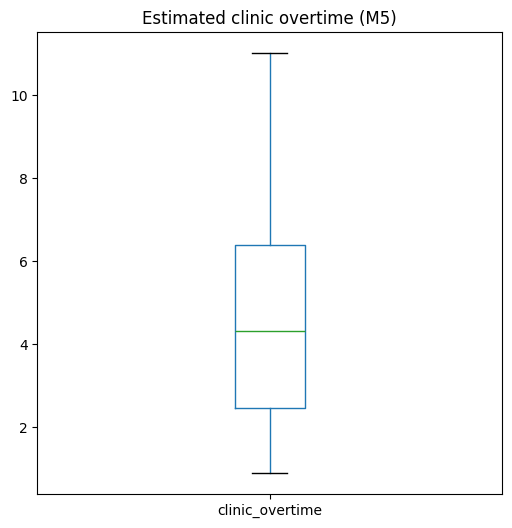

In [537]:
# Calculate estimated clinic overtime
overbooked_df_M5["clinic_overtime"] = overbooked_df_M5["joint_probability"] * (overbooked_df_M5["very_high_appt_duration"] + overbooked_df_M5["original_overbooked_appt_duration"])

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (M5):", overbooked_df_M5["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (M5):", overbooked_df_M5["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df_M5["clinic_overtime"].quantile(0.75) - overbooked_df_M5["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df_M5.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (M5)")
plt.show()

Mean of weeks waiting reduced (M5): 49.27067669172932
Median of weeks waiting reduced (M5): 51.5


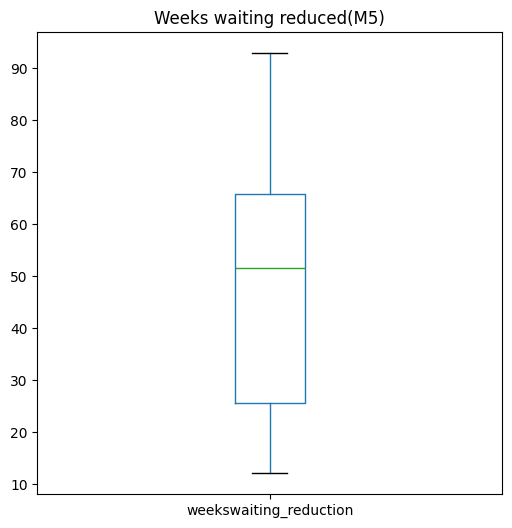

In [538]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
overbooked_df_M5["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df_M5["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df_M5["true_weekswaiting"] = overbooked_df_M5["original_overbooked_weekswaiting"] + overbooked_df_M5["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df_M5["weekswaiting_reduction"] = overbooked_df_M5["true_weekswaiting"] - overbooked_df_M5["lead_time_change_weeks"].abs()
print("Mean of weeks waiting reduced (M5):", overbooked_df_M5["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced (M5):", overbooked_df_M5["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df_M5.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(M5)")
plt.show()

### Compare the 5 models

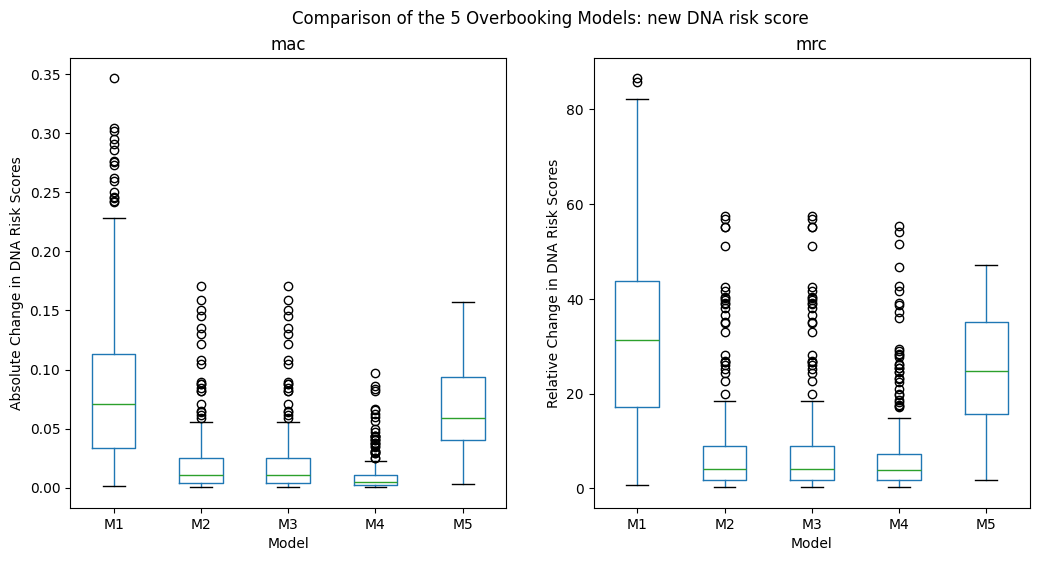

In [552]:
# Compare new DNA risk score of all 5 models

# Convert M1_rescheduled_df to a DF
M1_rescheduled_df = pd.DataFrame(M1_rescheduled_df)

# Combine the data into one dataframe with an additional column to differentiate them
M1_rescheduled_df['Model'] = 'M1'
overbooked_df['Model'] = 'M2'
overbooked_df_M3['Model'] = 'M3'
overbooked_df_M4['Model'] = 'M4'
overbooked_df_M5['Model'] = 'M5'

columns_to_keep = ["lead_time_change_days", "joint_probability", "clinic_overtime", "weekswaiting_reduction", "mac", "mrc", "Model"]
combined_df = pd.concat([M1_rescheduled_df[["lead_time_change_days", "weekswaiting_reduction", "mac", "mrc", "Model"]],
                         overbooked_df[columns_to_keep], 
                         overbooked_df_M3[columns_to_keep], 
                         overbooked_df_M4[columns_to_keep], 
                         overbooked_df_M5[columns_to_keep]])

# print(type(combined_df))

# Create the subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot MAC
combined_df.boxplot(column="mac", by="Model", ax=ax[0], grid=False)
# ax[0].set_title("Mean Absolute Change (MAC)")
ax[0].set_xlabel("Model")
ax[0].set_ylabel("Absolute Change in DNA Risk Scores")

# Plot MRC
combined_df.boxplot(column="mrc", by="Model", ax=ax[1],grid=False)
# ax[1].set_title("Mean Relative Change (MRC)")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("Relative Change in DNA Risk Scores")

# Adjust layout for better spacing
plt.suptitle('Comparison of the 5 Overbooking Models: new DNA risk score')
# plt.tight_layout()

# Show plot
plt.show()


In [540]:
# Compare the percentage of appointments rescheduled across all 5 models
perc_rescheduled_appts_combined = {
    "Model": ["M1","M2", "M3", "M4", "M5"],
    "Percentage of Appointments Rescheduled": [perc_rescheduled_appts_M1, perc_rescheduled_appts_M2, perc_rescheduled_appts_M3, perc_rescheduled_appts_M4, perc_rescheduled_appts_M5]
}

# Convert to df
perc_rescheduled_appts_combined = pd.DataFrame(perc_rescheduled_appts_combined)

# Round up to 2 decimal places
perc_rescheduled_appts_combined["Percentage of Appointments Rescheduled"] = perc_rescheduled_appts_combined["Percentage of Appointments Rescheduled"].round(2)

perc_rescheduled_appts_combined

,Model,Percentage of Appointments Rescheduled
0,M1,65.58
1,M2,10.73
2,M3,10.73
3,M4,9.92
4,M5,1.72


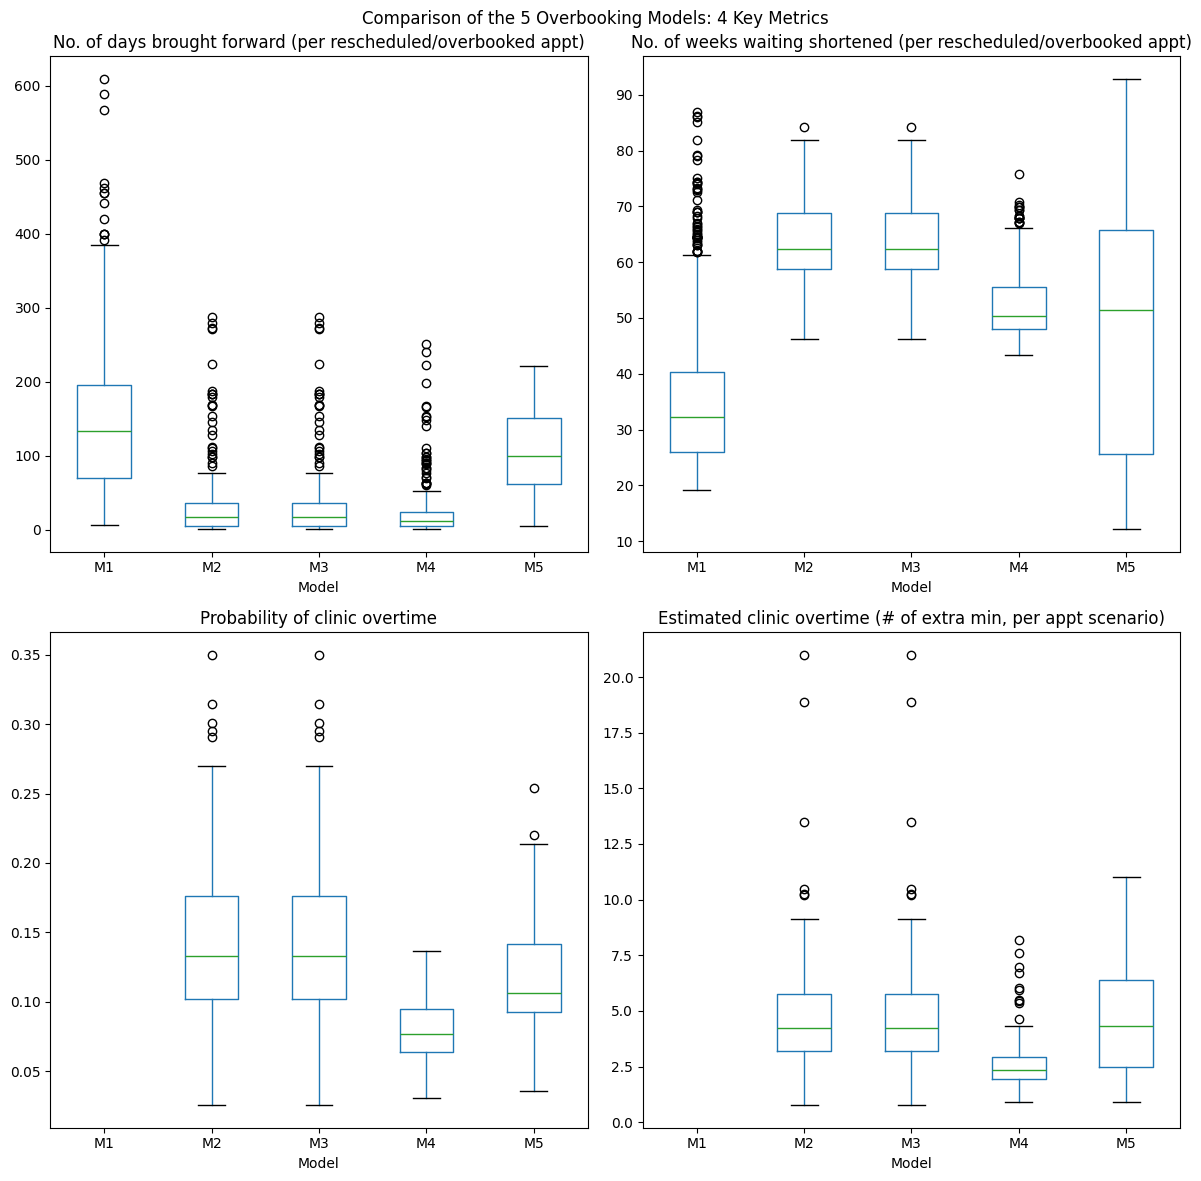

In [541]:
# Compare the 4 key metrics of all 5 models

# Convert 'lead_time_change_days' to absolute values
combined_df['lead_time_change_days'] = combined_df['lead_time_change_days'].abs()

# Create the subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Number of days brought forward boxplot
combined_df.boxplot(column="lead_time_change_days", by="Model", ax=axs[0, 0], grid=False)
axs[0, 0].set_title("No. of days brought forward (per rescheduled/overbooked appt)")

# Weeks waiting reduction boxplot
combined_df.boxplot(column="weekswaiting_reduction", by="Model", ax=axs[0, 1], grid=False)
axs[0, 1].set_title("No. of weeks waiting shortened (per rescheduled/overbooked appt)")

# Joint probability boxplot
combined_df.boxplot(column="joint_probability", by="Model", ax=axs[1, 0], grid=False)
axs[1, 0].set_title("Probability of clinic overtime")

# Clinic overtime boxplot
combined_df.boxplot(column="clinic_overtime", by="Model", ax=axs[1, 1], grid=False)
axs[1, 1].set_title("Estimated clinic overtime (# of extra min, per appt scenario)")

# Adjust layout for better spacing
plt.suptitle('Comparison of the 5 Overbooking Models: 4 Key Metrics')
plt.tight_layout()

# Show plot
plt.show()

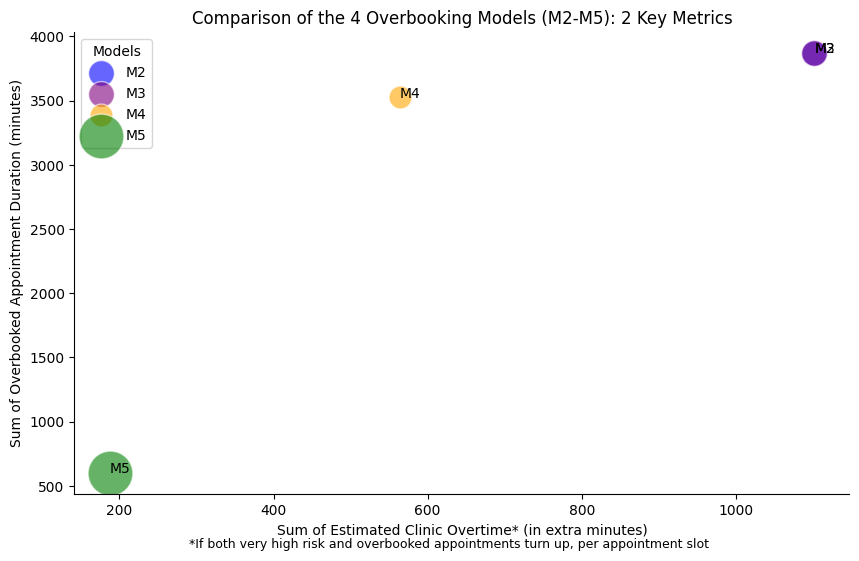

In [551]:
# Create a dictionary with comparison metrics for the 4 models
compare_model = {
    'Model': [
        overbooked_df["Model"].unique()[0],
        overbooked_df_M3["Model"].unique()[0],
        overbooked_df_M4["Model"].unique()[0],
        overbooked_df_M5["Model"].unique()[0]
              ],
    'Sum of Estimated Clinic Overtime (extra minutes)': [
        overbooked_df["clinic_overtime"].sum(),
        overbooked_df_M3["clinic_overtime"].sum(), 
        overbooked_df_M4["clinic_overtime"].sum(), 
        overbooked_df_M5["clinic_overtime"].sum()
    ],
    'Sum of Overbooked Appointment Duration (minutes)': [
        overbooked_df["appt_duration"].sum(), 
        overbooked_df_M3["appt_duration"].sum(),
        overbooked_df_M4["appt_duration"].sum(),
        overbooked_df_M5["original_overbooked_appt_duration"].sum()
    ],
    'Avg. lead time change (days)': [
        overbooked_df["lead_time_change_days"].abs().mean(),
        overbooked_df_M3["lead_time_change_days"].abs().mean(),
        overbooked_df_M4["lead_time_change_days"].abs().mean(),
        overbooked_df_M5["lead_time_change_days"].abs().mean()
    ]
}

# Convert it into a DataFrame
df = pd.DataFrame(compare_model)
df

# Plot the scatter plot with lead time change as size of marker
plt.figure(figsize=(10, 6))

# Scatter plot for each version
colors = ['blue', 'purple', 'orange', 'green']
for i in range(len(df)):
    plt.scatter(df['Sum of Estimated Clinic Overtime (extra minutes)'][i], 
                df['Sum of Overbooked Appointment Duration (minutes)'][i], 
                s=df['Avg. lead time change (days)'][i] * 10, # Scale marker size
                color=colors[i],
                alpha=0.6,
                edgecolors="w",
                label=df['Model'][i])

# Adding labels to each point
for i, txt in enumerate(df['Model']):
    plt.annotate(txt, (df['Sum of Estimated Clinic Overtime (extra minutes)'][i], df['Sum of Overbooked Appointment Duration (minutes)'][i]), fontsize=10)

plt.xlabel('Sum of Estimated Clinic Overtime* (in extra minutes)')
plt.ylabel('Sum of Overbooked Appointment Duration (minutes)')
plt.title('Comparison of the 4 Overbooking Models (M2-M5): 2 Key Metrics')
plt.legend(title='Models')
plt.grid(True)


# Remove the top and right spines (outside borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hide grid lines
ax.grid(False)

# Adding the footnote
plt.figtext(0.5, 0.02, '*If both very high risk and overbooked appointments turn up, per appointment slot', ha='center', fontsize=9)

plt.show()

### Result: end output

In [543]:
# Overbooked df

In [544]:
# # of overbooked appts per day

In [545]:
# Mean clinic overtime per day (per week?)
overbooked_df_M4["clinic_overtime"].groupby(overbooked_df_M4["very_high_appt_date"]).mean()

very_high_appt_date
2024-05-02    2.426947
2024-05-08    2.493604
2024-05-09    1.068316
2024-05-10    2.458249
2024-05-14    4.066138
                ...   
2025-07-31    2.696168
2025-08-11         NaN
2025-08-19         NaN
2025-09-15    2.114738
2025-10-09         NaN
Name: clinic_overtime, Length: 156, dtype: float64

### Graphics for report

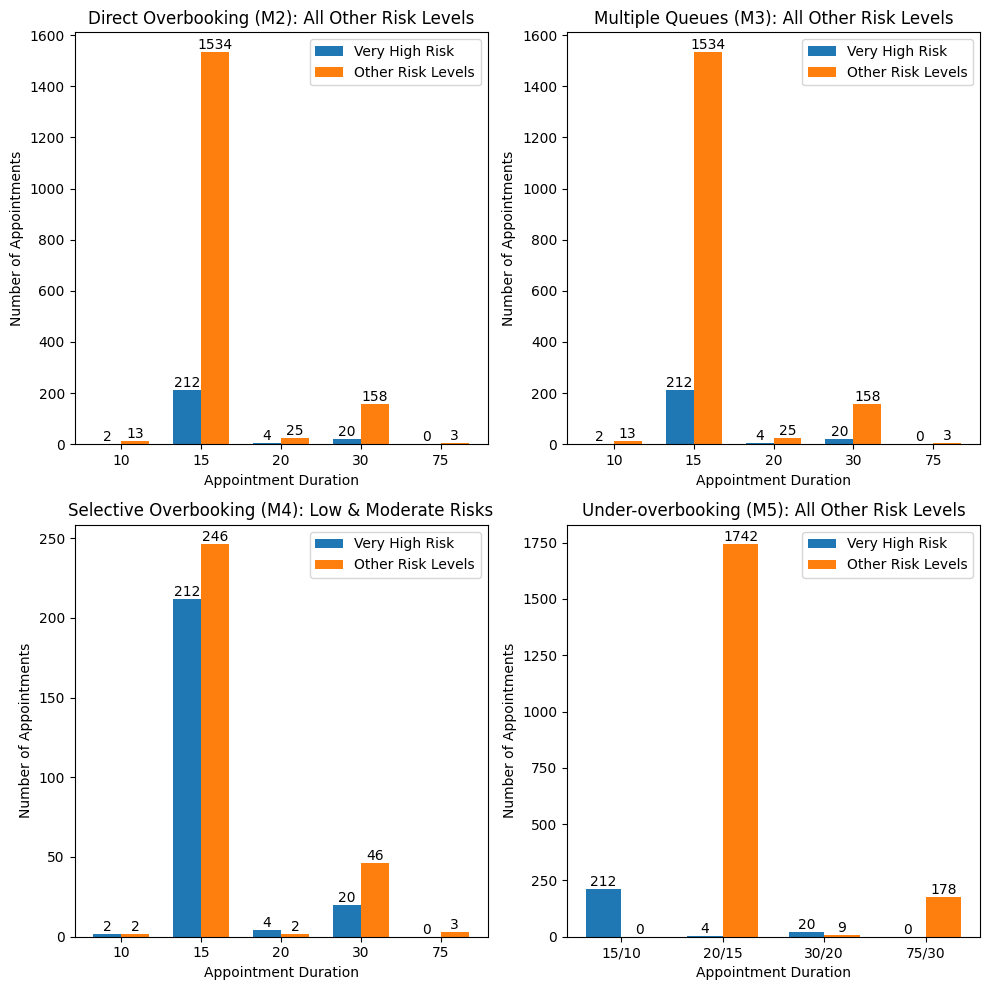

In [546]:
# Define data for all plots
very_high_counts_list = [
    [len(surgeon_new_very_high_10), len(surgeon_new_very_high_15), len(surgeon_new_very_high_20), len(surgeon_new_very_high_30), len(surgeon_new_very_high_75)],
    [len(surgeon_new_very_high_10), len(surgeon_new_very_high_15), len(surgeon_new_very_high_20), len(surgeon_new_very_high_30), len(surgeon_new_very_high_75)],  # Same as Plot 1
    [len(surgeon_new_very_high_10), len(surgeon_new_very_high_15), len(surgeon_new_very_high_20), len(surgeon_new_very_high_30), len(surgeon_new_very_high_75)],
    [len(surgeon_new_very_high_15), len(surgeon_new_very_high_20), len(surgeon_new_very_high_30), len(surgeon_new_very_high_75)]  # Removed first element
]

other_risk_counts_list = [
    [len(queue10), len(queue15), len(queue20), len(queue30), len(queue75)],
    [len(queue10), len(queue15), len(queue20), len(queue30), len(queue75)],  # Same as Plot 1
    [len(queue10_M4), len(queue15_M4), len(queue20_M4), len(queue30_M4), len(queue75_M4)],
    [len(queue10_M5), len(queue15_M5), len(queue20_M5), len(queue30_M5)]
]

durations_list = [
    [10, 15, 20, 30, 75],
    [10, 15, 20, 30, 75],  # Same as Plot 1
    [10, 15, 20, 30, 75],
    ["15/10", "20/15", "30/20", "75/30"]
]

titles = [
    "Direct Overbooking (M2): All Other Risk Levels",
    "Multiple Queues (M3): All Other Risk Levels", 
    "Selective Overbooking (M4): Low & Moderate Risks",
    "Under-overbooking (M5): All Other Risk Levels"
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the subplots
for i, ax in enumerate(axs.flat):
    ind = range(len(durations_list[i]))
    width = 0.35  # Width of the bars
    
    # Create the bar plots
    bars1 = ax.bar(ind, very_high_counts_list[i], width, label="Very High Risk")
    bars2 = ax.bar([j + width for j in ind], other_risk_counts_list[i], width, label="Other Risk Levels")
    
    # Add labels, title, and legend
    ax.set_xlabel("Appointment Duration")
    ax.set_ylabel("Number of Appointments")
    ax.set_title(titles[i])
    ax.set_xticks([j + width / 2 for j in ind])
    ax.set_xticklabels(durations_list[i])
    ax.legend()
    
    # Add data values on top of the bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height}",
            ha="center",
            va="bottom"
        )

    for bar in bars2:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height}",
            ha="center",
            va="bottom"
        )

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()
